In [1]:
import warnings
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.util
import iris
import iris.analysis
import iris.coord_categorisation
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
# def m2km(x, pos):
#     """Convert meters to kilometers when plotting axis labels"""
#     return int(x * 1e-3)

In [3]:
from aeolus.coord import add_cyclic_point_to_cube, replace_z_coord

In [4]:
from util_commons import EXPERIMENTS, GASES, LAYERS, SEASONS
from util_mypaths import path_to_processed
from util_proc_func import fdr_threshold, mmr_to_vmr_in_ppn

In [5]:
warnings.filterwarnings("ignore", module="iris")
plt.rcParams["mathtext.default"] = "regular"

In [6]:
# Switches
base_exp = "BASE"
sens_exp = "FULL"
var = "o3"
w_rono2 = True
savefig = False
publish = False
layer = "BL"  # BL or FT

In [7]:
SPECIES = [
    "ch4",
    "c2h6",
    "c3h8",
    "no",
    "no2",
    "hono",
    "ho2no2",
    "hno3",
    "n2o5",
    "pan",
    "ppan",
    "meono2",
    "etono2",
    "nprono2",
    "iprono2",
    "o3",
]

In [8]:
# Read data
vrbls = {}
for exp in [base_exp, sens_exp]:
    vrbls[exp] = {}
    for sp in SPECIES:
        cube_in_mmr = iris.load_cube(
            str(path_to_processed / EXPERIMENTS[exp] / f"{EXPERIMENTS[exp]}_{sp}.nc"), sp
        )
        cube_in_vmr = mmr_to_vmr_in_ppn(cube_in_mmr, GASES[sp]["molar_mass"], GASES[sp]["ppn"])
        cube_on_hlevs = replace_z_coord(cube_in_vmr)
        cube_on_hlevs.rename(sp)
        cube_on_hlevs.units = GASES[sp]["ppn"]
        # Remove the first year as a spin up
        cube_on_hlevs = cube_on_hlevs[12::, ...]
        # Add season and year coordinates
        iris.coord_categorisation.add_season(cube_on_hlevs, "time", name="season")
        iris.coord_categorisation.add_season_year(cube_on_hlevs, "time", name="year")
        vrbls[exp][sp] = cube_on_hlevs

In [9]:
# Calculate NOx and NOy
for exp in [base_exp, sens_exp]:
    nox_raw = vrbls[exp]["no"] + vrbls[exp]["no2"]
    noy_raw = (
        nox_raw
        + vrbls[exp]["hono"]
        + vrbls[exp]["ho2no2"]
        + vrbls[exp]["hno3"]
        + vrbls[exp]["n2o5"]
        + vrbls[exp]["pan"]
        + vrbls[exp]["ppan"]
    )
    if w_rono2:
        rono2_raw = (
            vrbls[exp]["meono2"]
            + vrbls[exp]["etono2"]
            + vrbls[exp]["nprono2"]
            + vrbls[exp]["iprono2"]
        )
        rono2_raw.convert_units("ppbv")
        noy_raw = noy_raw + rono2_raw
    nox_raw.rename("nox")
    noy_raw.rename("noy")
    nox_raw.units = "ppbv"
    noy_raw.units = "ppbv"
    vrbls[exp]["nox"] = nox_raw
    vrbls[exp]["noy"] = noy_raw

In [10]:
# Simplify dimensions
nlons = vrbls[exp]["nox"].coord("longitude").shape[0]
nlats = vrbls[exp]["nox"].coord("latitude").shape[0]
nlevs = vrbls[exp]["nox"].coord("level_height")[0:23].shape[0]
lons = vrbls[exp]["nox"].coord("longitude").points
lats = vrbls[exp]["nox"].coord("latitude").points

In [11]:
# # Path to figures
# path_to_figs = Path.cwd().parent.parent.parent / "results" / f"{sens_job}-{base_job}" / var
# path_to_figs.mkdir(exist_ok=True)
# if publish:
#     mpl.rcParams["xtick.labelsize"] = 12  # 25
#     mpl.rcParams["ytick.labelsize"] = 12  # 25
#     mpl.rcParams["axes.titlesize"] = 12  # 40
#     mpl.rcParams["axes.labelsize"] = 12  # 30
#     plt.rcParams["font.size"] = 12  # 30

### Boundary layer seasonal means

In [12]:
VRBLS = {}
for exp in [base_exp, sens_exp]:
    VRBLS[exp] = {}
    for var in vrbls[exp].keys():
        VRBLS[exp][var] = {}
        for ssn in SEASONS:
            ssn_constr = iris.Constraint(season=ssn)
            # Extract a time series of seasonal means
            ssn_ts = (
                vrbls[exp][var]
                .extract(ssn_constr & LAYERS["BL"]["iris_constr"])
                .collapsed(["level_height"], iris.analysis.MEAN)
            )
            # Calculate seasonal means
            _ssn_mean = ssn_ts.collapsed("year", iris.analysis.MEAN)
            ssn_mean = add_cyclic_point_to_cube(_ssn_mean)
            VRBLS[exp][var][ssn] = {"ssn_ts": ssn_ts, "ssn_mean": ssn_mean}

In [15]:
def calc_stat_tests(cube_ctrl, cube_sens, pval_thresh=0.05):
    """WRITEME"""
    result_cube_dummy = next(cube_ctrl.slices_over("time"))
    nlats, nlons = result_cube_dummy.shape
    pval_arr = np.empty([nlats, nlons])
    for j in range(nlats):
        for i in range(nlons):
            # Check if the seasonal mean differences between the control and
            # sensitivity experiments are normally distributed using the Shapiro–Wilk test
            shapiro_pval = stats.shapiro(cube_ctrl.data[:, j, i] - cube_sens.data[:, j, i])[1]
            # See if the seasonal mean differences between the two experiments are statitically significant using
            # (a) paired sample t-test if data is normally distributed, and
            # (b) Wilcoxon signed-rank test if data is not normally distributed
            if shapiro_pval > pval_thresh:
                pval_arr[j, i] = stats.ttest_rel(cube_ctrl.data[:, j, i], cube_sens.data[:, j, i])[
                    1
                ]
            else:
                pval_arr[j, i] = stats.wilcoxon(cube_ctrl.data[:, j, i], cube_sens.data[:, j, i])[1]
    out = result_cube_dummy.copy(data=pval_arr)
    out.rename("p_value_of_stats_test")
    out.units = 1
    return out


def stipple_bl(pval_cube, fdr, central_long=0):
    """Stipple areas where p-values are NOT statistically significant.
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA"""
    xx, yy = np.meshgrid(pval_cube.coord("longitude").points, pval_cube.coord("latitude").points)
    if fdr:
        thresh = fdr_threshold(pval_cube.data)  # false discovery rate threshold
    else:
        thresh = 0.05
    sig_points = pval_cube.data < thresh
    xxp = xx[sig_points] - central_long
    yyp = yy[sig_points]
    return (xxp, yyp)


# aa = iris.util.mask_cube(a, pval_cube.data > fdr_threshold(pval_cube.data))

In [17]:
for sens_exp in ["FULL"]:
    for var in ["o3"]:  # tqdm(VRBLS["BASE"].keys()):
        for ssn in tqdm(SEASONS, leave=False):
            # Calculate seasonal mean differences and add a cyclic point
            ssn_mean_diff_abs = (
                VRBLS[sens_exp][var][ssn]["ssn_mean"] - VRBLS[base_exp][var][ssn]["ssn_mean"]
            )
            ssn_mean_diff_pct = ssn_mean_diff_abs / VRBLS[base_exp][var][ssn]["ssn_mean"] * 100
            # Stats
            pval_cube = calc_stat_tests(
                VRBLS[base_exp][var][ssn]["ssn_ts"], VRBLS[sens_exp][var][ssn]["ssn_ts"]
            )
            VRBLS[sens_exp][var][ssn] = {
                "ssn_mean_diff_abs": ssn_mean_diff_abs,
                "ssn_mean_diff_pct": ssn_mean_diff_pct,
                "pval_cube": pval_cube,
            }

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# # Boundary layer seasonal mean difference plotting parameters
# if var == "o3":
#     bl_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0, 110, 10))
# elif var == "nox":
#     bl_mean_cf_kwargs = dict(
#         transform=ccrs.PlateCarree(), levels=np.arange(0, 16000, 2000) * 1e-3
#     )  # in ppb
# elif var == "noy":
#     bl_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0, 11, 1))
# elif var == "hno3":
#     bl_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0, 9, 1))
# elif var == "pan":
#     bl_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0, 2, 0.2))
# bl_diff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap="RdBu_r")
# bl_pval_sc_kwargs = dict(transform=ccrs.PlateCarree(), s=10, c="k", marker=".", alpha=1)

# fdr_bl = True  # turn FDR on/off

In [81]:
VRBLS[base_exp][var][ssn]["ssn_mean"].data.min(), VRBLS[base_exp][var][ssn]["ssn_mean"].data.max()

(9.998893, 71.1168)

In [85]:
VRBLS[sens_exp][var][ssn]["ssn_mean_diff_abs"].data.min(), VRBLS[sens_exp][var][ssn]["ssn_mean_diff_abs"].data.max()

(-2.5903397, 3.7723885)

In [86]:
VRBLS[sens_exp][var][ssn]["ssn_mean_diff_pct"].data.min(), VRBLS[sens_exp][var][ssn]["ssn_mean_diff_pct"].data.max()

(-7.9140625, 17.227158)

In [96]:
if var == "o3":
    ssn_mean_levs=np.arange(0, 90, 10)
    ssn_mean_diff_abs_levs = np.arange(-5,6,1)
    ssn_mean_diff_pct_levs = np.arange(-50,60,10)
ssn_mean_cf_kws = dict(transform=ccrs.PlateCarree(), cmap="viridis", levels=ssn_mean_levs)
ssn_mean_diff_abs_cf_kws = dict(transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=ssn_mean_diff_abs_levs)
ssn_mean_diff_pct_cf_kws = dict(transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=ssn_mean_diff_pct_levs)
pval_cube_sc_kws = dict(transform=ccrs.PlateCarree(), s=5, c="grey", marker=".", alpha=1)

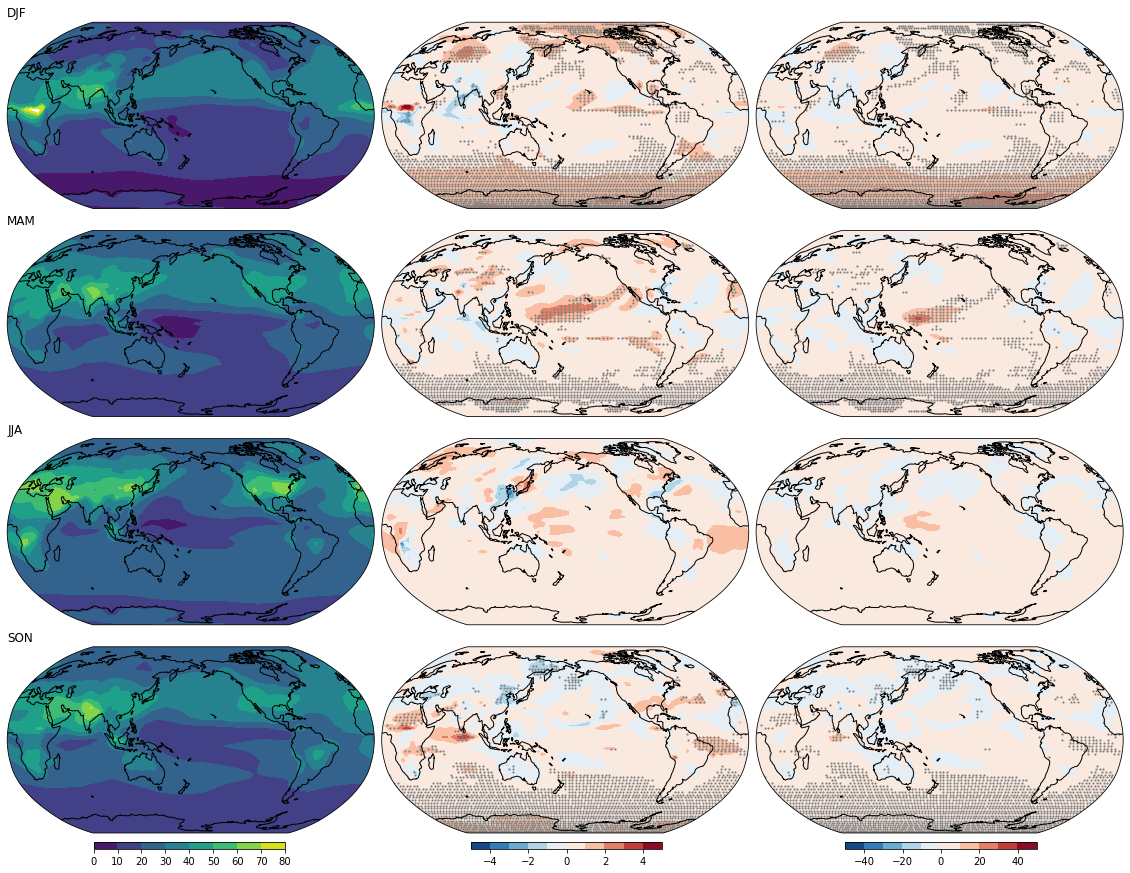

In [97]:
fig, ax = plt.subplots(
    nrows=4,
    ncols=3,
    figsize=(20, 20),
    subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)),
    facecolor="w",
)
lons = VRBLS[base_exp][var][ssn]["ssn_mean"].coord("longitude").points
lats = VRBLS[base_exp][var][ssn]["ssn_mean"].coord("latitude").points
for ssn, iax in zip(SEASONS, ax[:, 0].flatten()):
    iax.set_title(ssn.upper(), loc="left")
    p0 = iax.contourf(lons, lats, VRBLS[base_exp][var][ssn]["ssn_mean"].data, **ssn_mean_cf_kws)
for ssn, iax in zip(SEASONS, ax[:, 1].flatten()):
    p1 = iax.contourf(
        lons, lats, VRBLS[sens_exp][var][ssn]["ssn_mean_diff_abs"].data, **ssn_mean_diff_abs_cf_kws
    )
    iax.scatter(*stipple_bl(VRBLS[sens_exp][var][ssn]["pval_cube"], True), **pval_cube_sc_kws)
for ssn, iax in zip(SEASONS, ax[:, 2].flatten()):
    p2 = iax.contourf(
        lons, lats, VRBLS[sens_exp][var][ssn]["ssn_mean_diff_pct"].data, **ssn_mean_diff_pct_cf_kws
    )
    iax.scatter(*stipple_bl(VRBLS[sens_exp][var][ssn]["pval_cube"], True), **pval_cube_sc_kws)
for iax in ax.flatten():
    iax.set_global()
    iax.coastlines()
fig.subplots_adjust(hspace=-0.55, wspace=0.02)
cax0 = fig.add_axes([0.185, 0.21, 0.133, 0.005]) # [left, bottom, width, height]
cax1 = fig.add_axes([0.447, 0.21, 0.133, 0.005])
cax2 = fig.add_axes([0.707, 0.21, 0.133, 0.005])
fig.colorbar(p0, cax=cax0, orientation="horizontal")  # , label=var_dict["str"][var] + ", ppbv")
fig.colorbar(p1, cax=cax1, orientation="horizontal")  # , label="$\Delta$" + var_dict["str"][var] + ", pptv"
fig.colorbar(p2, cax=cax2, orientation="horizontal");  # , label="$\Delta$" + var_dict["str"][var] + ", %"

In [ ]:
# Find max boundary layer seasonal mean
print(max(np.max(base_bl_djf_mean.data), np.max(sens_bl_djf_mean.data)))
print(max(np.max(base_bl_mam_mean.data), np.max(sens_bl_mam_mean.data)))
print(max(np.max(base_bl_jja_mean.data), np.max(sens_bl_jja_mean.data)))
print(max(np.max(base_bl_son_mean.data), np.max(sens_bl_son_mean.data)))
# Check for false discovery
print(
    "FDR: ",
    fdr_threshold(bl_djf_p),
    fdr_threshold(bl_mam_p),
    fdr_threshold(bl_jja_p),
    fdr_threshold(bl_son_p),
)

O3
- CHEM-BASE: 94.47014 67.15967 67.81758 70.99066 FDR:  4.85273119226e-05 0.0 0.0 0.0
- MARI-BASE: 92.44435 67.586365 67.81758 70.99066 FDR:  0.027376744728255603 0.0 0.0 0.005844106297217985
- FULL-BASE: 94.54146 67.43663 69.066635 70.99066 FDR:  0.031184292595637896 0.0 0.0 0.020536157398506963


NOx
- CHEM-BASE: 11668.469 4949.531 4329.739 6865.997 FDR:  0.0 2.892861808945264e-06 0.0 0.0
- MARI-BASE: 11766.111 4710.869 4259.5176 6865.997 FDR:  0.02852347045766753 0.018205539355684766 0.0010468282441881188 0.028057889931287383
- FIRE-BASE OLD: 12099.605 4788.483 4193.323 7031.552 FDR:  3.8932452319590724e-05 4.198681931104611e-05 0.0 0.000414584762280698
- FULL-BASE: 11344.539 4850.6953 4271.53 6865.997 FDR:  0.028931485644320184 0.007651341880011242 0.0008697695897533976 0.029682844739491277


NOy
- CHEM-BASE w RONO2: 8.978415 5.5679717 4.799015 6.931694 FDR:  0.029899259778976416 0.03429721382258202 0.03727214163164655 0.036449192986989155
- MARI-BASE w RONO2: 8.978415 5.6025095 5.122735 6.931694 FDR:  0.04146987553672822 0.04173921305855974 0.046621018325410435 0.041750136029032124
- FULL-BASE w RONO2: 8.978415 5.4651318 4.9566727 6.931694 FDR:  0.05120419181653776 0.049069504170404024 0.06573031357481997 0.05468546610219659
- FULL-BASE wo RONO2: 8.978415 5.4347267 4.9211984 6.931694 FDR:  0.024367906601376044 1.8490486323717958e-06 0.0 0.025868126507294417


PAN
- FULL-BASE: 1.5613912 1.0689497 1.5783508 1.5641047 FDR:  0.015569602712221907 0.0 0.0 0.024857962143616387


HNO3
- CHEM-BASE: 7.361723 5.3020487 4.418888 6.1663923 FDR:  0.0 0.0 0.0 0.0
- FULL-BASE: 7.361723 5.151022 4.4384193 6.1663923 FDR:  0.023690122954317744 0.006188829114011086 0.0 0.021179567242207025


Other
- UPDT-ORIG O3: 93.72969 67.18241 68.10031 69.59426 FDR:  0.0 0.0 0.0 0.0

In [ ]:
# Find min and max absolute boundary layer seasonal mean difference
print(
    min(
        [
            np.min(cyc_bl_djf_diff.data),
            np.min(cyc_bl_mam_diff.data),
            np.min(cyc_bl_jja_diff.data),
            np.min(cyc_bl_son_diff.data),
        ]
    )
)
print(
    max(
        [
            np.max(cyc_bl_djf_diff.data),
            np.max(cyc_bl_mam_diff.data),
            np.max(cyc_bl_jja_diff.data),
            np.max(cyc_bl_son_diff.data),
        ]
    )
)
# Find min and max % boundary layer seasonal mean difference
print(
    min(
        [
            np.min(cyc_bl_djf_diff.data / cyc_base_bl_djf_mean.data * 100),
            np.min(cyc_bl_mam_diff.data / cyc_base_bl_mam_mean.data * 100),
            np.min(cyc_bl_jja_diff.data / cyc_base_bl_jja_mean.data * 100),
            np.min(cyc_bl_son_diff.data / cyc_base_bl_son_mean.data * 100),
        ]
    )
)
print(
    max(
        [
            np.max(cyc_bl_djf_diff.data / cyc_base_bl_djf_mean.data * 100),
            np.max(cyc_bl_mam_diff.data / cyc_base_bl_mam_mean.data * 100),
            np.max(cyc_bl_jja_diff.data / cyc_base_bl_jja_mean.data * 100),
            np.max(cyc_bl_son_diff.data / cyc_base_bl_son_mean.data * 100),
        ]
    )
)

- CHEM-BASE O3: -6.4614296 6.8441925 -13.359586 19.08021
- MARI-BASE O3: -5.0836563 7.6860695 -12.6582365 24.622028
- FULL-BASE O3: -5.875229 6.597744 -12.732835 30.897097
- CHEM-BASE NOy w RONO2: -0.98270035 1.184288 -28.148079 124.478615
- MARI-BASE NOy w RONO2: -0.8188243 1.3464642 -20.732325 771.98444
- FULL-BASE NOy w RONO2: -0.9853883 1.2527189 -22.743944 843.24054


- FULL-BASE NOy wo RONO2: -1.012675 1.2200456 -37.405403 110.088776


- UPDT-ORIG O3: -2.209877 3.6024399 -10.71041 19.975046


BL NOx ppt
- CHEM-BASE: -1033.3164 617.0654 -43.902977 77.23121
- MARI-BASE: -596.1377 759.70215 -54.900146 171.99585
- FIRE-BASE OLD: -585.7612 1154.6606 -43.29081 88.9264
- FULL-BASE -768.6138 938.14844 -49.731968 187.58478

BL HNO3
- CHEM-BASE: -0.8868842 1.0311308 -41.136017 61.67733
- FULL-BASE: -0.9142959 1.0952353 -38.403996 148.60826

BL PAN
- FULL-BASE: -0.11146605 0.116983026 -46.594402 89.52184

In [ ]:
# Additional plotting parameteres for boundary layer seasonal mean summary
if var == "o3":
    bl_glb_absdiff_cf_kwargs = dict(
        transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-8, 9, 1)
    )
    bl_glb_pctdiff_cf_kwargs = dict(
        transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-35, 40, 5)
    )
elif var == "nox":
    bl_glb_absdiff_cf_kwargs = dict(
        transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-1200, 1400, 200)
    )
    bl_glb_pctdiff_cf_kwargs = dict(
        transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-200, 220, 20)
    )
elif var == "noy":
    bl_glb_absdiff_cf_kwargs = dict(
        transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-1.4, 1.6, 0.2)
    )
    bl_glb_pctdiff_cf_kwargs = dict(
        transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-140, 160, 20), extend="max"
    )
elif var == "hno3":
    bl_glb_absdiff_cf_kwargs = dict(
        transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-1.2, 1.4, 0.2)
    )
    bl_glb_pctdiff_cf_kwargs = dict(
        transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-150, 175, 25)
    )
elif var == "pan":
    bl_glb_absdiff_cf_kwargs = dict(
        transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-0.15, 0.20, 0.05)
    )
    bl_glb_pctdiff_cf_kwargs = dict(
        transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-100, 120, 20)
    )

In [ ]:
# fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
# p30 = ax.contourf(cyclic_lons, lats, cyc_bl_djf_diff.data, transform=ccrs.PlateCarree(), cmap='RdBu_r',)#, **bl_glb_absdiff_cf_kwargs)
# ax.contour(cyclic_lons, lats, cyc_bl_djf_diff.data, levels=[1.5], transform=ccrs.PlateCarree(), cmap='RdBu_r')
# ax.coastlines(color='grey')
# fig.colorbar(p30, orientation='horizontal')

In [ ]:
fig, ax = plt.subplots(
    nrows=4,
    ncols=4,
    figsize=(20, 20),
    subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)),
    facecolor="w",
)
if var == "nox":
    ax[0, 0].contourf(
        cyclic_lons, lats, cyc_base_bl_djf_mean.data * 1e-3, **bl_mean_cf_kwargs
    )  # in ppb
    ax[1, 0].contourf(cyclic_lons, lats, cyc_base_bl_mam_mean.data * 1e-3, **bl_mean_cf_kwargs)
    ax[2, 0].contourf(cyclic_lons, lats, cyc_base_bl_jja_mean.data * 1e-3, **bl_mean_cf_kwargs)
    p30 = ax[3, 0].contourf(
        cyclic_lons, lats, cyc_base_bl_son_mean.data * 1e-3, **bl_mean_cf_kwargs
    )
else:
    ax[0, 0].contourf(cyclic_lons, lats, cyc_base_bl_djf_mean.data, **bl_mean_cf_kwargs)
    ax[1, 0].contourf(cyclic_lons, lats, cyc_base_bl_mam_mean.data, **bl_mean_cf_kwargs)
    ax[2, 0].contourf(cyclic_lons, lats, cyc_base_bl_jja_mean.data, **bl_mean_cf_kwargs)
    p30 = ax[3, 0].contourf(cyclic_lons, lats, cyc_base_bl_son_mean.data, **bl_mean_cf_kwargs)

ax[0, 1].contourf(cyclic_lons, lats, cyc_bl_djf_diff.data, **bl_glb_absdiff_cf_kwargs)
ax[0, 2].contourf(
    cyclic_lons,
    lats,
    cyc_bl_djf_diff.data / cyc_base_bl_djf_mean.data * 100,
    **bl_glb_pctdiff_cf_kwargs,
)

ax[1, 1].contourf(cyclic_lons, lats, cyc_bl_mam_diff.data, **bl_glb_absdiff_cf_kwargs)
ax[1, 2].contourf(
    cyclic_lons,
    lats,
    cyc_bl_mam_diff.data / cyc_base_bl_mam_mean.data * 100,
    **bl_glb_pctdiff_cf_kwargs,
)

ax[2, 1].contourf(cyclic_lons, lats, cyc_bl_jja_diff.data, **bl_glb_absdiff_cf_kwargs)
ax[2, 2].contourf(
    cyclic_lons,
    lats,
    cyc_bl_jja_diff.data / cyc_base_bl_jja_mean.data * 100,
    **bl_glb_pctdiff_cf_kwargs,
)

p31 = ax[3, 1].contourf(cyclic_lons, lats, cyc_bl_son_diff.data, **bl_glb_absdiff_cf_kwargs)
p32 = ax[3, 2].contourf(
    cyclic_lons,
    lats,
    cyc_bl_son_diff.data / cyc_base_bl_son_mean.data * 100,
    **bl_glb_pctdiff_cf_kwargs,
)

ax[0, 1].contour(
    cyclic_lons, lats, cyc_bl_djf_diff.data, levels=[5], transform=ccrs.PlateCarree(), cmap="RdBu_r"
)
# ax[0,2].contour(cyclic_lons, lats, cyc_bl_djf_diff.data/cyc_base_bl_djf_mean.data*100, levels=[185], transform=ccrs.PlateCarree(), cmap='RdBu_r')

ax[0, 3].scatter(*stipple_bl(bl_djf_diff, bl_djf_p, fdr_bl), **bl_pval_sc_kwargs)
ax[1, 3].scatter(*stipple_bl(bl_mam_diff, bl_mam_p, fdr_bl), **bl_pval_sc_kwargs)
ax[2, 3].scatter(*stipple_bl(bl_jja_diff, bl_jja_p, fdr_bl), **bl_pval_sc_kwargs)
ax[3, 3].scatter(*stipple_bl(bl_son_diff, bl_son_p, fdr_bl), **bl_pval_sc_kwargs)

fig.subplots_adjust(hspace=-0.78, wspace=0.01)
cax0 = fig.add_axes([0.146, 0.29, 0.15, 0.005])
cax1 = fig.add_axes([0.34, 0.29, 0.15, 0.005])
cax2 = fig.add_axes([0.535, 0.29, 0.15, 0.005])
if var == "nox":
    fig.colorbar(p30, cax=cax0, orientation="horizontal", label=var_dict["str"][var] + ", ppbv")
    fig.colorbar(
        p31, cax=cax1, orientation="horizontal", label="$\Delta$" + var_dict["str"][var] + ", pptv"
    )
    fig.colorbar(
        p32, cax=cax2, orientation="horizontal", label="$\Delta$" + var_dict["str"][var] + ", %"
    )
else:
    fig.colorbar(p30, cax=cax0, orientation="horizontal", label=var_dict["str"][var] + ", ppbv")
    fig.colorbar(
        p31, cax=cax1, orientation="horizontal", label="$\Delta$" + var_dict["str"][var] + ", ppbv"
    )
    fig.colorbar(
        p32, cax=cax2, orientation="horizontal", label="$\Delta$" + var_dict["str"][var] + ", %"
    )
fig.text(0.13, 0.695, "DJF", fontsize=12)
fig.text(0.13, 0.595, "MAM", fontsize=12)
fig.text(0.13, 0.495, "JJA", fontsize=12)
fig.text(0.13, 0.395, "SON", fontsize=12)
if bl:
    fig.suptitle("Boundary layer (0-2 km)", y=0.73, weight="bold")
else:
    fig.suptitle("Free troposphere (5-10 km)", y=0.73, weight="bold")
ax[0, 0].set_title(f"{base_exp}")
for iax in ax[0, 1:].flatten():
    iax.set_title(f"{sens_exp}-{base_exp}")
for iax in ax.flatten():
    iax.set_global()
for iax in ax[:, 0].flatten():
    iax.coastlines(color="k")
for iax in ax[0:4, 1:].flatten():
    iax.coastlines(color="grey")
# if savefig:
#     if bl:
#         fig.savefig(path_to_figs / f'{sens_exp.lower()}_{base_exp.lower()}_{var}_pbl_ssn_mean_diff.png', bbox_inches='tight', dpi=300)
#     else:
#         fig.savefig(path_to_figs / f'{sens_exp.lower()}_{base_exp.lower()}_{var}_frt_ssn_mean_diff.png', bbox_inches='tight', dpi=300)

In [ ]:
break

#### RONO2 % of NOy

In [ ]:
if w_rono2:
    # Extract time series of boundary layer (0-2 km) seasonal means
    rno3_bl_djf = (
        rno3.extract(iris.Constraint(season="djf")).aggregated_by(
            ["year", "season"], iris.analysis.MEAN
        )[:, 0:10, ...]
    ).collapsed("level_height", iris.analysis.MEAN)
    rno3_bl_mam = (
        rno3.extract(iris.Constraint(season="mam")).aggregated_by(
            ["year", "season"], iris.analysis.MEAN
        )[:, 0:10, ...]
    ).collapsed("level_height", iris.analysis.MEAN)
    rno3_bl_jja = (
        rno3.extract(iris.Constraint(season="jja")).aggregated_by(
            ["year", "season"], iris.analysis.MEAN
        )[:, 0:10, ...]
    ).collapsed("level_height", iris.analysis.MEAN)
    rno3_bl_son = (
        rno3.extract(iris.Constraint(season="son")).aggregated_by(
            ["year", "season"], iris.analysis.MEAN
        )[:, 0:10, ...]
    ).collapsed("level_height", iris.analysis.MEAN)
    # Calculate boundary layer seasonal means
    rno3_bl_djf_mean = rno3_bl_djf.collapsed("year", iris.analysis.MEAN)
    rno3_bl_mam_mean = rno3_bl_mam.collapsed("year", iris.analysis.MEAN)
    rno3_bl_jja_mean = rno3_bl_jja.collapsed("year", iris.analysis.MEAN)
    rno3_bl_son_mean = rno3_bl_son.collapsed("year", iris.analysis.MEAN)
    # Add cyclic point for plotting on a global map
    cyc_rno3_bl_djf_mean = cartopy.util.add_cyclic_point(rno3_bl_djf_mean.data)
    cyc_rno3_bl_mam_mean = cartopy.util.add_cyclic_point(rno3_bl_mam_mean.data)
    cyc_rno3_bl_jja_mean = cartopy.util.add_cyclic_point(rno3_bl_jja_mean.data)
    cyc_rno3_bl_son_mean = cartopy.util.add_cyclic_point(rno3_bl_son_mean.data)
    # Find max boundary layer seasonal mean
    print(np.max(rno3_bl_djf_mean.data) * 1e3)
    print(np.max(rno3_bl_mam_mean.data) * 1e3)
    print(np.max(rno3_bl_jja_mean.data) * 1e3)
    print(np.max(rno3_bl_son_mean.data) * 1e3)
# rno3_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0,110,10))

In [ ]:
if w_rono2:
    fig, ax = plt.subplots(
        nrows=4,
        ncols=2,
        figsize=(12, 12),
        subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)),
        facecolor="w",
    )
    p00 = ax[0, 0].contourf(
        cyclic_lons, lats, cyc_sens_bl_djf_mean.data, transform=ccrs.PlateCarree()
    )
    ax[1, 0].contourf(cyclic_lons, lats, cyc_sens_bl_mam_mean.data, transform=ccrs.PlateCarree())
    ax[2, 0].contourf(cyclic_lons, lats, cyc_sens_bl_jja_mean.data, transform=ccrs.PlateCarree())
    ax[3, 0].contourf(cyclic_lons, lats, cyc_sens_bl_son_mean.data, transform=ccrs.PlateCarree())

    p01 = ax[0, 1].contourf(
        cyclic_lons,
        lats,
        cyc_rno3_bl_djf_mean.data * 100 / cyc_sens_bl_djf_mean.data,
        transform=ccrs.PlateCarree(),
        levels=np.arange(0, 110, 10),
    )
    ax[1, 1].contourf(
        cyclic_lons,
        lats,
        cyc_rno3_bl_mam_mean.data * 100 / cyc_sens_bl_mam_mean.data,
        transform=ccrs.PlateCarree(),
        levels=np.arange(0, 110, 10),
    )
    ax[2, 1].contourf(
        cyclic_lons,
        lats,
        cyc_rno3_bl_jja_mean.data * 100 / cyc_sens_bl_jja_mean.data,
        transform=ccrs.PlateCarree(),
        levels=np.arange(0, 110, 10),
    )
    ax[3, 1].contourf(
        cyclic_lons,
        lats,
        cyc_rno3_bl_son_mean.data * 100 / cyc_sens_bl_son_mean.data,
        transform=ccrs.PlateCarree(),
        levels=np.arange(0, 110, 10),
    )

    p01x = ax[0, 1].contour(
        lons,
        lats,
        rno3_bl_djf_mean.data * 100 / sens_bl_djf_mean.data,
        transform=ccrs.PlateCarree(),
        levels=[10, 50, 80],
        colors="w",
    )
    p11x = ax[1, 1].contour(
        lons,
        lats,
        rno3_bl_mam_mean.data * 100 / sens_bl_mam_mean.data,
        transform=ccrs.PlateCarree(),
        levels=[10, 50, 80],
        colors="w",
    )
    p21x = ax[2, 1].contour(
        lons,
        lats,
        rno3_bl_jja_mean.data * 100 / sens_bl_jja_mean.data,
        transform=ccrs.PlateCarree(),
        levels=[10, 50, 80],
        colors="w",
    )
    p31x = ax[3, 1].contour(
        lons,
        lats,
        rno3_bl_son_mean.data * 100 / sens_bl_son_mean.data,
        transform=ccrs.PlateCarree(),
        levels=[10, 50, 80],
        colors="w",
    )
    ax[0, 1].clabel(p01x, inline=1, fmt="%1.0f")
    ax[1, 1].clabel(p11x, inline=1, fmt="%1.0f")
    ax[2, 1].clabel(p21x, inline=1, fmt="%1.0f")
    ax[3, 1].clabel(p31x, inline=1, fmt="%1.0f")

    fig.subplots_adjust(hspace=0.1, wspace=-0.1)
    cax00 = fig.add_axes([0.215, 0.1, 0.23, 0.01])
    fig.colorbar(p00, cax=cax00, orientation="horizontal", label="$NO_y$, ppbv")
    cax01 = fig.add_axes([0.58, 0.1, 0.23, 0.01])
    fig.colorbar(
        p01, cax=cax01, orientation="horizontal", label="$\sum$$C_1$-$C_3$ $RONO_2$ % of $NO_y$"
    )
    fig.suptitle(f"Boundary layer (0-2 km)\n{sens_exp}", y=0.92, weight="bold")
    for iax in ax.flatten():
        iax.coastlines(color="k")

### Zonal seasonal means

In [ ]:
# Calculate zonal mean for each month
base_znl_mean = base[:, 0:23, ...].collapsed("longitude", iris.analysis.MEAN)
sens_znl_mean = sens[:, 0:23, ...].collapsed("longitude", iris.analysis.MEAN)
# Extract time series of zonal seasonal means
base_znl_djf = base_znl_mean.extract(iris.Constraint(season="djf")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)
sens_znl_djf = sens_znl_mean.extract(iris.Constraint(season="djf")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)
base_znl_mam = base_znl_mean.extract(iris.Constraint(season="mam")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)
sens_znl_mam = sens_znl_mean.extract(iris.Constraint(season="mam")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)
base_znl_jja = base_znl_mean.extract(iris.Constraint(season="jja")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)
sens_znl_jja = sens_znl_mean.extract(iris.Constraint(season="jja")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)
base_znl_son = base_znl_mean.extract(iris.Constraint(season="son")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)
sens_znl_son = sens_znl_mean.extract(iris.Constraint(season="son")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)
# Check if zonal seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
shapiro_znl_djf_p = np.empty([nlevs, nlats])
shapiro_znl_mam_p = np.empty([nlevs, nlats])
shapiro_znl_jja_p = np.empty([nlevs, nlats])
shapiro_znl_son_p = np.empty([nlevs, nlats])
for i, lev in enumerate(base.coord("level_height")[0:23].points):
    for j, lat in enumerate(base.coord("latitude").points):
        shapiro_znl_djf_p[i, j] = stats.shapiro(
            base_znl_djf.data[:, i, j] - sens_znl_djf.data[:, i, j]
        )[1]
        shapiro_znl_mam_p[i, j] = stats.shapiro(
            base_znl_mam.data[:, i, j] - sens_znl_mam.data[:, i, j]
        )[1]
        shapiro_znl_jja_p[i, j] = stats.shapiro(
            base_znl_jja.data[:, i, j] - sens_znl_jja.data[:, i, j]
        )[1]
        shapiro_znl_son_p[i, j] = stats.shapiro(
            base_znl_son.data[:, i, j] - sens_znl_son.data[:, i, j]
        )[1]
# See if zonal seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
znl_djf_p = np.empty([nlevs, nlats])
znl_mam_p = np.empty([nlevs, nlats])
znl_jja_p = np.empty([nlevs, nlats])
znl_son_p = np.empty([nlevs, nlats])
for i, lev in enumerate(base.coord("level_height")[0:23].points):
    for j, lat in enumerate(base.coord("latitude").points):
        if shapiro_znl_djf_p[i, j] > 0.05:
            znl_djf_p[i, j] = stats.ttest_rel(
                base_znl_djf.data[:, i, j], sens_znl_djf.data[:, i, j]
            )[1]
        else:
            znl_djf_p[i, j] = stats.wilcoxon(
                base_znl_djf.data[:, i, j], sens_znl_djf.data[:, i, j]
            )[1]
        if shapiro_znl_mam_p[i, j] > 0.05:
            znl_mam_p[i, j] = stats.ttest_rel(
                base_znl_mam.data[:, i, j], sens_znl_mam.data[:, i, j]
            )[1]
        else:
            znl_mam_p[i, j] = stats.wilcoxon(
                base_znl_mam.data[:, i, j], sens_znl_mam.data[:, i, j]
            )[1]
        if shapiro_znl_jja_p[i, j] > 0.05:
            znl_jja_p[i, j] = stats.ttest_rel(
                base_znl_jja.data[:, i, j], sens_znl_jja.data[:, i, j]
            )[1]
        else:
            znl_jja_p[i, j] = stats.wilcoxon(
                base_znl_jja.data[:, i, j], sens_znl_jja.data[:, i, j]
            )[1]
        if shapiro_znl_son_p[i, j] > 0.05:
            znl_son_p[i, j] = stats.ttest_rel(
                base_znl_son.data[:, i, j], sens_znl_son.data[:, i, j]
            )[1]
        else:
            znl_son_p[i, j] = stats.wilcoxon(
                base_znl_son.data[:, i, j], sens_znl_son.data[:, i, j]
            )[1]
# Calculate zonal seasonal mean differences
base_znl_djf_mean = base_znl_djf.collapsed("year", iris.analysis.MEAN)
base_znl_mam_mean = base_znl_mam.collapsed("year", iris.analysis.MEAN)
base_znl_jja_mean = base_znl_jja.collapsed("year", iris.analysis.MEAN)
base_znl_son_mean = base_znl_son.collapsed("year", iris.analysis.MEAN)
sens_znl_djf_mean = sens_znl_djf.collapsed("year", iris.analysis.MEAN)
sens_znl_mam_mean = sens_znl_mam.collapsed("year", iris.analysis.MEAN)
sens_znl_jja_mean = sens_znl_jja.collapsed("year", iris.analysis.MEAN)
sens_znl_son_mean = sens_znl_son.collapsed("year", iris.analysis.MEAN)
znl_djf_diff = sens_znl_djf_mean - base_znl_djf_mean
znl_mam_diff = sens_znl_mam_mean - base_znl_mam_mean
znl_jja_diff = sens_znl_jja_mean - base_znl_jja_mean
znl_son_diff = sens_znl_son_mean - base_znl_son_mean
# Find max zonal seasonal mean
print(max(np.max(base_znl_djf_mean.data), np.max(sens_znl_djf_mean.data)))
print(max(np.max(base_znl_mam_mean.data), np.max(sens_znl_mam_mean.data)))
print(max(np.max(base_znl_jja_mean.data), np.max(sens_znl_jja_mean.data)))
print(max(np.max(base_znl_son_mean.data), np.max(sens_znl_son_mean.data)))
# Check for false discovery
print(
    "FDR: ",
    fdr_threshold(znl_djf_p),
    fdr_threshold(znl_mam_p),
    fdr_threshold(znl_jja_p),
    fdr_threshold(znl_son_p),
)

- CHEM-BASE O3: 239.92675399780273 304.44007619222003 220.81518999735516 200.28447914123535 FDR:  0.0 0.0 0.0 0.0
- MARI-BASE O3: 256.53899574279785 312.3972810109457 228.8615900675456 201.7245871225993 FDR:  0.015697085783157084 0.0 0.0 0.02324822896113234
- FULL-BASE O3: 246.73359489440918 297.44246101379395 225.37927500406903 200.35796419779462 FDR:  0.028341324207195196 0.0 0.013296548807684348 0.019616658169879304
- CHEM-BASE NOy w RONO2: 1.0860120157400766 1.1680093606313071 1.6296287775039673 1.2575127283732095 FDR:  0.03138079931446896 0.047629546620460914 0.04852924508823632 0.046267120071516954
- MARI-BASE NOy w RONO2: 1.0858202477296195 1.1660320361455283 1.670572822292646 1.2719601790110269 FDR:  0.03040812441092543 0.04057126632061856 0.04545631866899116 0.0394323523805973
- FULL-BASE NOy w RONO2: 1.0858202477296195 1.1638031601905823 1.6601046919822693 1.2575127283732095 FDR:  0.05515039051308593 0.07579562119399044 0.08598145311141674 0.07104373877612884


- FULL-BASE NOy wo RONO2: 1.0858202477296195 1.1514161676168442 1.6382570316394172 1.2575127283732095 FDR:  0.016272175817194517 0.0 0.0 0.016019524727490988


- UPDT-ORIG O3: 257.8860677083333 318.3748629534686 230.74353564227073 206.9941 FDR:  0.008743366758852273 0.011190619708664792 0.03506754572078748 0.011682821681109025


- UPDT-ORIG CH4: 2057.216595685041 2007.3067559136284 2099.8666110568574 2105.4226 FDR:  0.05786186771139498 0.0854612321722828 0.06122474239293917 0.07250443975657658

In [ ]:
# Zonal seasonal mean plotting parameters
if var == "o3":
    znl_mean_cf_kwargs = dict(levels=np.arange(0, 130, 10), extend="max")
elif var == "noy":
    znl_mean_cf_kwargs = dict(levels=np.arange(0, 2, 0.2))
elif var == "ch4":
    znl_mean_cf_kwargs = dict(levels=np.arange(1700, 2200, 50))
znl_mean_pc_kwargs = dict(cmap="RdBu_r")
znl_mean_cr_kwargs = dict(levels=[-10, -5, 0, 5, 10], cmap="RdBu_r")
znl_pval_kwargs = dict(s=5, c="k", marker=".", alpha=1)
fdr_znl = True  # turn FDR on/off


def stipple_zonal(cube, pval_arr, fdr):
    """Stipple areas where p-values are statistically significant.
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA"""
    xOrg = cube.coord("latitude").points
    yOrg = cube.coord("level_height").points
    nlon = len(xOrg)
    nlat = len(yOrg)
    xData = np.reshape(np.tile(xOrg, nlat), pval_arr.shape)
    yData = np.reshape(np.repeat(yOrg, nlon), pval_arr.shape)
    if fdr:
        thresh = fdr_threshold(pval_arr)  # false discovery rate threshold
    else:
        thresh = 0.05
    sigPoints = pval_arr < thresh
    xPoints = xData[sigPoints]
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)


lats = base.coord("latitude").points
levs = base.coord("level_height").points[0:23]

In [ ]:
# Find min and max absolute zonal seasonal mean difference
print(
    min(
        [
            np.min(znl_djf_diff.data),
            np.min(znl_mam_diff.data),
            np.min(znl_jja_diff.data),
            np.min(znl_son_diff.data),
        ]
    )
)
print(
    max(
        [
            np.max(znl_djf_diff.data),
            np.max(znl_mam_diff.data),
            np.max(znl_jja_diff.data),
            np.max(znl_son_diff.data),
        ]
    )
)
# Find min and max % zonal seasonal mean difference
print(
    min(
        [
            np.min(znl_djf_diff.data / base_znl_djf_mean.data * 100),
            np.min(znl_mam_diff.data / base_znl_mam_mean.data * 100),
            np.min(znl_jja_diff.data / base_znl_jja_mean.data * 100),
            np.min(znl_son_diff.data / base_znl_son_mean.data * 100),
        ]
    )
)
print(
    max(
        [
            np.max(znl_djf_diff.data / base_znl_djf_mean.data * 100),
            np.max(znl_mam_diff.data / base_znl_mam_mean.data * 100),
            np.max(znl_jja_diff.data / base_znl_jja_mean.data * 100),
            np.max(znl_son_diff.data / base_znl_son_mean.data * 100),
        ]
    )
)

- CHEM-BASE O3: -11.705768585205078 36.959577560424805 -7.1608906130925405 15.344309728289055
- MARI-BASE O3: -2.884126663208008 45.04723739624029 -3.704269622045892 20.246400682614734
- FULL-BASE O3: -10.710908253987611 33.24661191304523 -5.8698472778794555 19.024541231085976
- CHEM-BASE NOy w RONO2: -0.06400503218173981 0.04748198886712385 -13.731033471996446 46.23153934451011
- MARI-BASE NOy w RONO2: -0.04005942493677139 0.06000681594014168 -10.844401412985377 714.103718245858
- FULL-BASE NOy w RONO2: -0.058240221192439434 0.07530604799588536 -12.41017950191274 753.3187754558724


- FULL-BASE NOy wo RONO2: -0.0684942019482454 0.05248606950044632 -15.602732055084134 64.173010955936


- UPDT-ORIG O3: -12.849262661404055 8.592537491409871 -6.834523580060805 8.465218733246624


- UPDT-ORIG CH4: -13.023625126591469 6.038036205151002 -0.744315102817345 0.34134886146972687

In [ ]:
# Additional plotting parameters for zonal seasonal mean summary
if var == "o3":
    znl_glb_absdiff_pc_kwargs = dict(
        cmap="RdBu_r", levels=np.arange(-2, 2.5, 0.5), extend="both"
    )  # RONO2 -3,4,1
    znl_glb_pctdiff_pc_kwargs = dict(cmap="RdBu_r", levels=np.arange(-10, 11, 1))  # RONO2 -25,30,5
elif var == "noy":
    znl_glb_absdiff_pc_kwargs = dict(cmap="RdBu_r", levels=np.arange(-0.08, 0.1, 0.02))
    znl_glb_pctdiff_pc_kwargs = dict(cmap="RdBu_r", levels=np.arange(-70, 80, 10), extend="max")
elif var == "ch4":
    znl_glb_absdiff_pc_kwargs = dict(cmap="RdBu_r", levels=np.arange(-14, 16, 2))
    znl_glb_pctdiff_pc_kwargs = dict(cmap="RdBu_r", levels=np.arange(-1, 1.2, 0.2))

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 12), facecolor="w", sharex=True, sharey=True)
p00 = ax[0, 0].contourf(lats, levs, base_znl_djf_mean.data, **znl_mean_cf_kwargs)
p01 = ax[0, 1].contourf(lats, levs, znl_djf_diff.data, **znl_glb_absdiff_pc_kwargs)
p02 = ax[0, 2].contourf(
    lats, levs, znl_djf_diff.data / base_znl_djf_mean.data * 100, **znl_glb_pctdiff_pc_kwargs
)
p02x = ax[0, 2].contour(
    lats, levs, znl_djf_diff.data / base_znl_djf_mean.data * 100, **znl_mean_cr_kwargs
)
ax[0, 2].clabel(p02x, inline=1, fmt="%1.0f")
# p01.cmap.set_under('w')
# p01.cmap.set_over('w')

ax[1, 0].contourf(lats, levs, base_znl_mam_mean.data, **znl_mean_cf_kwargs)
ax[1, 1].contourf(lats, levs, znl_mam_diff.data, **znl_glb_absdiff_pc_kwargs)
ax[1, 2].contourf(
    lats, levs, znl_mam_diff.data / base_znl_mam_mean.data * 100, **znl_glb_pctdiff_pc_kwargs
)
p12x = ax[1, 2].contour(
    lats, levs, znl_mam_diff.data / base_znl_mam_mean.data * 100, **znl_mean_cr_kwargs
)
ax[1, 2].clabel(p12x, inline=1, fmt="%1.0f")

ax[2, 0].contourf(lats, levs, base_znl_jja_mean.data, **znl_mean_cf_kwargs)
ax[2, 1].contourf(lats, levs, znl_jja_diff.data, **znl_glb_absdiff_pc_kwargs)
ax[2, 2].contourf(
    lats, levs, znl_jja_diff.data / base_znl_jja_mean.data * 100, **znl_glb_pctdiff_pc_kwargs
)
p22x = ax[2, 2].contour(
    lats, levs, znl_jja_diff.data / base_znl_jja_mean.data * 100, **znl_mean_cr_kwargs
)
ax[2, 2].clabel(p22x, inline=1, fmt="%1.0f")

p30 = ax[3, 0].contourf(lats, levs, base_znl_son_mean.data, **znl_mean_cf_kwargs)
p31 = ax[3, 1].contourf(lats, levs, znl_son_diff.data, **znl_glb_absdiff_pc_kwargs)
p32 = ax[3, 2].contourf(
    lats, levs, znl_son_diff.data / base_znl_son_mean.data * 100, **znl_glb_pctdiff_pc_kwargs
)
p32x = ax[3, 2].contour(
    lats, levs, znl_son_diff.data / base_znl_son_mean.data * 100, **znl_mean_cr_kwargs
)
ax[3, 2].clabel(p32x, inline=1, fmt="%1.0f")

cax0 = fig.add_axes([0.125, 0.06, 0.23, 0.01])
cax1 = fig.add_axes([0.395, 0.06, 0.23, 0.01])
cax2 = fig.add_axes([0.670, 0.06, 0.23, 0.01])
fig.colorbar(p30, cax=cax0, orientation="horizontal", label=var_dict["str"][var] + ", ppbv")
fig.colorbar(
    p31, cax=cax1, orientation="horizontal", label="$\Delta$" + var_dict["str"][var] + ", ppbv"
)  # , format=FuncFormatter(custom_ctcklbls))
fig.colorbar(
    p32, cax=cax2, orientation="horizontal", label="$\Delta$" + var_dict["str"][var] + ", %"
)
ax[0, 0].set_title(f"{base_exp}", loc="center")
ax[0, 1].set_title(f"{sens_exp}-{base_exp}", loc="center")
ax[0, 2].set_title(f"{sens_exp}-{base_exp}", loc="center")
ax[0, 0].set_title("DJF", loc="left")
ax[1, 0].set_title("MAM", loc="left")
ax[2, 0].set_title("JJA", loc="left")
ax[3, 0].set_title("SON", loc="left")
for iax in ax[:, 0].flatten():
    iax.set_ylabel("Height, km")
for iax in ax[3, :].flatten():
    iax.set_xlabel("Latitude")
for iax in ax.flatten():
    iax.margins(x=0, y=0)
    iax.yaxis.set_major_formatter(FuncFormatter(m2km))
for iax in ax[0, 1:3].flatten():
    iax.scatter(*stipple_zonal(znl_djf_diff, znl_djf_p, fdr_znl), **znl_pval_kwargs)
for iax in ax[1, 1:3].flatten():
    iax.scatter(*stipple_zonal(znl_mam_diff, znl_mam_p, fdr_znl), **znl_pval_kwargs)
for iax in ax[2, 1:3].flatten():
    iax.scatter(*stipple_zonal(znl_jja_diff, znl_jja_p, fdr_znl), **znl_pval_kwargs)
for iax in ax[3, 1:3].flatten():
    iax.scatter(*stipple_zonal(znl_son_diff, znl_son_p, fdr_znl), **znl_pval_kwargs)
if savefig:
    fig.savefig(
        path_to_figs / f"{sens_exp.lower()}_{base_exp.lower()}_{var}_znl_ssn_mean_diff.png",
        bbox_inches="tight",
        dpi=300,
    )

In [ ]:
break

### Free troposphere seasonal means

In [ ]:
# Find 5-10 km level height range
base.coord("level_height")[15:23].points / 1000

In [ ]:
# Extract time series of free troposphere (5-10 km) seasonal means
base_fre_djf = (
    base.extract(iris.Constraint(season="djf")).aggregated_by(
        ["year", "season"], iris.analysis.MEAN
    )[:, 15:23, ...]
).collapsed("level_height", iris.analysis.MEAN)
sens_fre_djf = (
    sens.extract(iris.Constraint(season="djf")).aggregated_by(
        ["year", "season"], iris.analysis.MEAN
    )[:, 15:23, ...]
).collapsed("level_height", iris.analysis.MEAN)
base_fre_mam = (
    base.extract(iris.Constraint(season="mam")).aggregated_by(
        ["year", "season"], iris.analysis.MEAN
    )[:, 15:23, ...]
).collapsed("level_height", iris.analysis.MEAN)
sens_fre_mam = (
    sens.extract(iris.Constraint(season="mam")).aggregated_by(
        ["year", "season"], iris.analysis.MEAN
    )[:, 15:23, ...]
).collapsed("level_height", iris.analysis.MEAN)
base_fre_jja = (
    base.extract(iris.Constraint(season="jja")).aggregated_by(
        ["year", "season"], iris.analysis.MEAN
    )[:, 15:23, ...]
).collapsed("level_height", iris.analysis.MEAN)
sens_fre_jja = (
    sens.extract(iris.Constraint(season="jja")).aggregated_by(
        ["year", "season"], iris.analysis.MEAN
    )[:, 15:23, ...]
).collapsed("level_height", iris.analysis.MEAN)
base_fre_son = (
    base.extract(iris.Constraint(season="son")).aggregated_by(
        ["year", "season"], iris.analysis.MEAN
    )[:, 15:23, ...]
).collapsed("level_height", iris.analysis.MEAN)
sens_fre_son = (
    sens.extract(iris.Constraint(season="son")).aggregated_by(
        ["year", "season"], iris.analysis.MEAN
    )[:, 15:23, ...]
).collapsed("level_height", iris.analysis.MEAN)
# Check if free troposphere seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
shapiro_fre_djf_p = np.empty([nlats, nlons])
shapiro_fre_mam_p = np.empty([nlats, nlons])
shapiro_fre_jja_p = np.empty([nlats, nlons])
shapiro_fre_son_p = np.empty([nlats, nlons])
for i, lat in enumerate(base.coord("latitude").points):
    for j, lon in enumerate(base.coord("longitude").points):
        shapiro_fre_djf_p[i, j] = stats.shapiro(
            base_fre_djf.data[:, i, j] - sens_fre_djf.data[:, i, j]
        )[1]
        shapiro_fre_mam_p[i, j] = stats.shapiro(
            base_fre_mam.data[:, i, j] - sens_fre_mam.data[:, i, j]
        )[1]
        shapiro_fre_jja_p[i, j] = stats.shapiro(
            base_fre_jja.data[:, i, j] - sens_fre_jja.data[:, i, j]
        )[1]
        shapiro_fre_son_p[i, j] = stats.shapiro(
            base_fre_son.data[:, i, j] - sens_fre_son.data[:, i, j]
        )[1]
# See if free troposphere seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
fre_djf_p = np.empty([nlats, nlons])
fre_mam_p = np.empty([nlats, nlons])
fre_jja_p = np.empty([nlats, nlons])
fre_son_p = np.empty([nlats, nlons])
for i, lat in enumerate(base.coord("latitude").points):
    for j, lon in enumerate(base.coord("longitude").points):
        if shapiro_fre_djf_p[i, j] > 0.05:
            fre_djf_p[i, j] = stats.ttest_rel(
                base_fre_djf.data[:, i, j], sens_fre_djf.data[:, i, j]
            )[1]
        else:
            fre_djf_p[i, j] = stats.wilcoxon(
                base_fre_djf.data[:, i, j], sens_fre_djf.data[:, i, j]
            )[1]
        if shapiro_fre_mam_p[i, j] > 0.05:
            fre_mam_p[i, j] = stats.ttest_rel(
                base_fre_mam.data[:, i, j], sens_fre_mam.data[:, i, j]
            )[1]
        else:
            fre_mam_p[i, j] = stats.wilcoxon(
                base_fre_mam.data[:, i, j], sens_fre_mam.data[:, i, j]
            )[1]
        if shapiro_fre_jja_p[i, j] > 0.05:
            fre_jja_p[i, j] = stats.ttest_rel(
                base_fre_jja.data[:, i, j], sens_fre_jja.data[:, i, j]
            )[1]
        else:
            fre_jja_p[i, j] = stats.wilcoxon(
                base_fre_jja.data[:, i, j], sens_fre_jja.data[:, i, j]
            )[1]
        if shapiro_fre_son_p[i, j] > 0.05:
            fre_son_p[i, j] = stats.ttest_rel(
                base_fre_son.data[:, i, j], sens_fre_son.data[:, i, j]
            )[1]
        else:
            fre_son_p[i, j] = stats.wilcoxon(
                base_fre_son.data[:, i, j], sens_fre_son.data[:, i, j]
            )[1]
#         # Welch's t-test
#         fre_djf_p[i, j] = stats.ttest_ind(base_fre_djf.data[:,i,j], sens_fre_djf.data[:,i,j], equal_var=False)[1]
#         fre_mam_p[i, j] = stats.ttest_ind(base_fre_mam.data[:,i,j], sens_fre_mam.data[:,i,j], equal_var=False)[1]
#         fre_jja_p[i, j] = stats.ttest_ind(base_fre_jja.data[:,i,j], sens_fre_jja.data[:,i,j], equal_var=False)[1]
#         fre_son_p[i, j] = stats.ttest_ind(base_fre_son.data[:,i,j], sens_fre_son.data[:,i,j], equal_var=False)[1]
# Calculate free troposphere seasonal mean differences
base_fre_djf_mean = base_fre_djf.collapsed("year", iris.analysis.MEAN)
base_fre_mam_mean = base_fre_mam.collapsed("year", iris.analysis.MEAN)
base_fre_jja_mean = base_fre_jja.collapsed("year", iris.analysis.MEAN)
base_fre_son_mean = base_fre_son.collapsed("year", iris.analysis.MEAN)
sens_fre_djf_mean = sens_fre_djf.collapsed("year", iris.analysis.MEAN)
sens_fre_mam_mean = sens_fre_mam.collapsed("year", iris.analysis.MEAN)
sens_fre_jja_mean = sens_fre_jja.collapsed("year", iris.analysis.MEAN)
sens_fre_son_mean = sens_fre_son.collapsed("year", iris.analysis.MEAN)
fre_djf_diff = sens_fre_djf_mean - base_fre_djf_mean
fre_mam_diff = sens_fre_mam_mean - base_fre_mam_mean
fre_jja_diff = sens_fre_jja_mean - base_fre_jja_mean
fre_son_diff = sens_fre_son_mean - base_fre_son_mean
# Add cyclic point for plotting on a global map
cyc_fre_djf_diff, cyclic_lons = cartopy.util.add_cyclic_point(
    fre_djf_diff.data, coord=fre_djf_diff.coord("longitude").points
)
cyc_fre_mam_diff = cartopy.util.add_cyclic_point(fre_mam_diff.data)
cyc_fre_jja_diff = cartopy.util.add_cyclic_point(fre_jja_diff.data)
cyc_fre_son_diff = cartopy.util.add_cyclic_point(fre_son_diff.data)
cyc_base_fre_djf_mean = cartopy.util.add_cyclic_point(base_fre_djf_mean.data)
cyc_base_fre_mam_mean = cartopy.util.add_cyclic_point(base_fre_mam_mean.data)
cyc_base_fre_jja_mean = cartopy.util.add_cyclic_point(base_fre_jja_mean.data)
cyc_base_fre_son_mean = cartopy.util.add_cyclic_point(base_fre_son_mean.data)
# Find max free troposphere seasonal mean
print(max(np.max(base_fre_djf_mean.data), np.max(sens_fre_djf_mean.data)))
print(max(np.max(base_fre_mam_mean.data), np.max(sens_fre_mam_mean.data)))
print(max(np.max(base_fre_jja_mean.data), np.max(sens_fre_jja_mean.data)))
print(max(np.max(base_fre_son_mean.data), np.max(sens_fre_son_mean.data)))
# Check for false discovery
print(
    "FDR: ",
    fdr_threshold(fre_djf_p),
    fdr_threshold(fre_mam_p),
    fdr_threshold(fre_jja_p),
    fdr_threshold(fre_son_p),
)

xojnb: 120.777016
143.42606
103.412575
98.72422
FDR:  0.0 0.0 0.0 0.0

xojnc: 121.10372
143.42606
103.412575
98.65314
FDR:  0.0 0.0 0.0 0.0

xojnh: 120.765015
149.06247
104.27327
98.522446
FDR:  0.0 0.0 0.0 0.0

xojng-xojnd: 114.26029
141.99973
103.587
96.9711
FDR:  0.0 0.0 0.0 0.0

In [ ]:
# Free troposphere seasonal mean difference plotting parameters
fre_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0, 175, 25))
fre_diff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap="RdBu_r")
fre_pval_sc_kwargs = dict(transform=ccrs.PlateCarree(), s=10, c="k", marker=".", alpha=0.2)
fdr_fre = True  # turn FDR on/off


def stipple_fre(cube, pval_arr, fdr, central_long=0):
    """Stipple areas where p-values are statistically significant.
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA"""
    xOrg = cube.coord("longitude").points
    yOrg = cube.coord("latitude").points
    nlon = len(xOrg)
    nlat = len(yOrg)
    xData = np.reshape(np.tile(xOrg, nlat), pval_arr.shape)
    yData = np.reshape(np.repeat(yOrg, nlon), pval_arr.shape)
    if fdr:
        thresh = fdr_threshold(pval_arr)  # false discovery rate threshold
    else:
        thresh = 0.05
    sigPoints = pval_arr < thresh
    xPoints = xData[sigPoints] - central_long
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)

In [ ]:
# Find min and max absolute free troposphere seasonal mean difference
print(
    min(
        [
            np.min(cyc_fre_djf_diff.data),
            np.min(cyc_fre_mam_diff.data),
            np.min(cyc_fre_jja_diff.data),
            np.min(cyc_fre_son_diff.data),
        ]
    )
)
print(
    max(
        [
            np.max(cyc_fre_djf_diff.data),
            np.max(cyc_fre_mam_diff.data),
            np.max(cyc_fre_jja_diff.data),
            np.max(cyc_fre_son_diff.data),
        ]
    )
)
# Find min and max % free troposphere seasonal mean difference
print(
    min(
        [
            np.min(cyc_fre_djf_diff.data / cyc_base_fre_djf_mean.data * 100),
            np.min(cyc_fre_mam_diff.data / cyc_base_fre_mam_mean.data * 100),
            np.min(cyc_fre_jja_diff.data / cyc_base_fre_jja_mean.data * 100),
            np.min(cyc_fre_son_diff.data / cyc_base_fre_son_mean.data * 100),
        ]
    )
)
print(
    max(
        [
            np.max(cyc_fre_djf_diff.data / cyc_base_fre_djf_mean.data * 100),
            np.max(cyc_fre_mam_diff.data / cyc_base_fre_mam_mean.data * 100),
            np.max(cyc_fre_jja_diff.data / cyc_base_fre_jja_mean.data * 100),
            np.max(cyc_fre_son_diff.data / cyc_base_fre_son_mean.data * 100),
        ]
    )
)

xojnb: -6.1123123
9.220947
-12.65836
11.857278

xojnc: -7.031479
11.983612
-10.37066
12.530851

xojnh: -7.2104187
21.54293
-13.351525
22.34018

xojng-xojnd: -11.205681
10.285858
-12.337628
12.704867

In [ ]:
# Additional plotting parameteres for free troposphere seasonal mean summary
fre_glb_absdiff_cf_kwargs = dict(
    transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-12, 14, 2)
)
fre_glb_pctdiff_cf_kwargs = dict(
    transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-14, 16, 2)
)  # , extend='both')

In [ ]:
fig, ax = plt.subplots(
    nrows=4,
    ncols=3,
    figsize=(12, 12),
    subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)),
    facecolor="w",
)
ax[0, 0].contourf(cyclic_lons, lats, cyc_base_fre_djf_mean.data, **fre_mean_cf_kwargs)
ax[0, 1].contourf(cyclic_lons, lats, cyc_fre_djf_diff.data, **fre_glb_absdiff_cf_kwargs)
ax[0, 2].contourf(
    cyclic_lons,
    lats,
    cyc_fre_djf_diff.data / cyc_base_fre_djf_mean.data * 100,
    **fre_glb_pctdiff_cf_kwargs,
)

ax[1, 0].contourf(cyclic_lons, lats, cyc_base_fre_mam_mean.data, **fre_mean_cf_kwargs)
ax[1, 1].contourf(cyclic_lons, lats, cyc_fre_mam_diff.data, **fre_glb_absdiff_cf_kwargs)
ax[1, 2].contourf(
    cyclic_lons,
    lats,
    cyc_fre_mam_diff.data / cyc_base_fre_mam_mean.data * 100,
    **fre_glb_pctdiff_cf_kwargs,
)

ax[2, 0].contourf(cyclic_lons, lats, cyc_base_fre_jja_mean.data, **fre_mean_cf_kwargs)
ax[2, 1].contourf(cyclic_lons, lats, cyc_fre_jja_diff.data, **fre_glb_absdiff_cf_kwargs)
ax[2, 2].contourf(
    cyclic_lons,
    lats,
    cyc_fre_jja_diff.data / cyc_base_fre_jja_mean.data * 100,
    **fre_glb_pctdiff_cf_kwargs,
)

p30 = ax[3, 0].contourf(cyclic_lons, lats, cyc_base_fre_son_mean.data, **fre_mean_cf_kwargs)
p31 = ax[3, 1].contourf(cyclic_lons, lats, cyc_fre_son_diff.data, **fre_glb_absdiff_cf_kwargs)
p32 = ax[3, 2].contourf(
    cyclic_lons,
    lats,
    cyc_fre_son_diff.data / cyc_base_fre_son_mean.data * 100,
    **fre_glb_pctdiff_cf_kwargs,
)

fig.subplots_adjust(hspace=-0.8, wspace=-0.5)
fig.tight_layout()
cax0 = fig.add_axes([0.02, 0.12, 0.3, 0.01])
cax1 = fig.add_axes([0.35, 0.12, 0.3, 0.01])
cax2 = fig.add_axes([0.68, 0.12, 0.3, 0.01])
fig.colorbar(p30, cax=cax0, orientation="horizontal", label=f"{str_var}, ppbv")
fig.colorbar(p31, cax=cax1, orientation="horizontal", label=f"$\Delta${str_var}, ppbv")
fig.colorbar(p32, cax=cax2, orientation="horizontal", label=f"$\Delta${str_var}, %")
fig.text(0.02, 0.84, "DJF")  # , fontsize=12)
fig.text(0.02, 0.66, "MAM")  # , fontsize=12)
fig.text(0.02, 0.48, "JJA")  # , fontsize=12)
fig.text(0.02, 0.31, "SON")  # , fontsize=12)
fig.suptitle("Free troposphere (5-10 km)", y=0.9, weight="bold")
ax[0, 0].set_title(f"{base_exp}")
ax[0, 1].set_title(f"{sens_exp}-{base_exp}")
ax[0, 2].set_title(f"{sens_exp}-{base_exp}")
for iax in ax[0, 1:3].flatten():
    iax.scatter(*stipple_fre(fre_djf_diff, fre_djf_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax[1, 1:3].flatten():
    iax.scatter(*stipple_fre(fre_mam_diff, fre_mam_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax[2, 1:3].flatten():
    iax.scatter(*stipple_fre(fre_jja_diff, fre_jja_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax[3, 1:3].flatten():
    iax.scatter(*stipple_fre(fre_son_diff, fre_son_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax.flatten():
    iax.set_global()
for iax in ax[:, 0].flatten():
    iax.coastlines(color="k")
for iax in ax[0:4, 1:].flatten():
    iax.coastlines(color="grey")
if savefig:
    fig.savefig(path_to_figs / f"{dir_var}_fre_seas_mean_diff.png", bbox_inches="tight")

In [ ]:
break

In [ ]:
# Plot boundary layer seasonal mean using 3 columns
# fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
# ax[0,0].contourf(cyclic_lons, lats, cyc_base_srf_djf_mean.data, **srf_mean_cf_kwargs)
# ax[0,1].contourf(cyclic_lons, lats, cyc_srf_djf_diff.data, **srf_glb_absdiff_cf_kwargs)
# ax[0,2].contourf(cyclic_lons, lats, cyc_srf_djf_diff.data/cyc_base_srf_djf_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

# ax[1,0].contourf(cyclic_lons, lats, cyc_base_srf_mam_mean.data, **srf_mean_cf_kwargs)
# ax[1,1].contourf(cyclic_lons, lats, cyc_srf_mam_diff.data, **srf_glb_absdiff_cf_kwargs)
# ax[1,2].contourf(cyclic_lons, lats, cyc_srf_mam_diff.data/cyc_base_srf_mam_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

# ax[2,0].contourf(cyclic_lons, lats, cyc_base_srf_jja_mean.data, **srf_mean_cf_kwargs)
# ax[2,1].contourf(cyclic_lons, lats, cyc_srf_jja_diff.data, **srf_glb_absdiff_cf_kwargs)
# ax[2,2].contourf(cyclic_lons, lats, cyc_srf_jja_diff.data/cyc_base_srf_jja_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

# p30 = ax[3,0].contourf(cyclic_lons, lats, cyc_base_srf_son_mean.data, **srf_mean_cf_kwargs)
# p31 = ax[3,1].contourf(cyclic_lons, lats, cyc_srf_son_diff.data, **srf_glb_absdiff_cf_kwargs)
# p32 = ax[3,2].contourf(cyclic_lons, lats, cyc_srf_son_diff.data/cyc_base_srf_son_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

# fig.subplots_adjust(hspace=-0.8, wspace=-0.5)
# fig.tight_layout()
# cax0 = fig.add_axes([0.02, 0.12, 0.3, 0.01])
# cax1 = fig.add_axes([0.35, 0.12, 0.3, 0.01])
# cax2 = fig.add_axes([0.68, 0.12, 0.3, 0.01])
# fig.colorbar(p30, cax=cax0, orientation='horizontal', label=f'{str_var}, ppbv')
# fig.colorbar(p31, cax=cax1, orientation='horizontal', label=f'$\Delta${str_var}, ppbv')
# fig.colorbar(p32, cax=cax2, orientation='horizontal', label=f'$\Delta${str_var}, %')
# fig.text(0.02, 0.84, 'DJF')#, fontsize=12)
# fig.text(0.02, 0.66, 'MAM')#, fontsize=12)
# fig.text(0.02, 0.48, 'JJA')#, fontsize=12)
# fig.text(0.02, 0.31, 'SON')#, fontsize=12)
# fig.suptitle('Surface', y=0.9, weight='bold')
# ax[0,0].set_title(f'{base_plt}')
# ax[0,1].set_title(f'{sens_plt}-{base_plt}')
# ax[0,2].set_title(f'{sens_plt}-{base_plt}')
# for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_srf(srf_djf_diff, srf_djf_p, fdr_srf), **srf_pval_sc_kwargs)
# for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_srf(srf_mam_diff, srf_mam_p, fdr_srf), **srf_pval_sc_kwargs)
# for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_srf(srf_jja_diff, srf_jja_p, fdr_srf), **srf_pval_sc_kwargs)
# for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_srf(srf_son_diff, srf_son_p, fdr_srf), **srf_pval_sc_kwargs)
# for iax in ax.flatten(): iax.set_global()
# for iax in ax[:,0].flatten(): iax.coastlines(color='k')
# for iax in ax[0:4,1:].flatten(): iax.coastlines(color='grey')
# if savefig: fig.savefig(path_to_figs / f'{dir_var}_srf_seas_mean_diff.png', bbox_inches='tight')

In [ ]:
# Plot zonal mean bigger picture
# fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,20), facecolor='w', sharex=True, sharey=True)
# p00 = ax[0,0].contourf(lats, levs, base_znl_djf_mean.data, **znl_mean_cf_kwargs)
# p01 = ax[0,1].contourf(lats, levs, znl_djf_diff.data, **znl_glb_absdiff_pc_kwargs)
# p02 = ax[0,2].contourf(lats, levs, znl_djf_diff.data/base_znl_djf_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
# p02x = ax[0,2].contour(lats, levs, znl_djf_diff.data/base_znl_djf_mean.data*100, **znl_mean_cr_kwargs)
# ax[0,2].clabel(p02x, inline=1, fmt='%1.0f')
# p01.cmap.set_under('w')
# p01.cmap.set_over('w')

# ax[1,0].contourf(lats, levs, base_znl_mam_mean.data, **znl_mean_cf_kwargs)
# ax[1,1].contourf(lats, levs, znl_mam_diff.data, **znl_glb_absdiff_pc_kwargs)
# ax[1,2].contourf(lats, levs, znl_mam_diff.data/base_znl_mam_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
# p12x = ax[1,2].contour(lats, levs, znl_mam_diff.data/base_znl_mam_mean.data*100, **znl_mean_cr_kwargs)
# ax[1,2].clabel(p12x, inline=1, fmt='%1.0f')

# ax[2,0].contourf(lats, levs, base_znl_jja_mean.data, **znl_mean_cf_kwargs)
# ax[2,1].contourf(lats, levs, znl_jja_diff.data, **znl_glb_absdiff_pc_kwargs)
# ax[2,2].contourf(lats, levs, znl_jja_diff.data/base_znl_jja_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
# p22x = ax[2,2].contour(lats, levs, znl_jja_diff.data/base_znl_jja_mean.data*100, **znl_mean_cr_kwargs)
# ax[2,2].clabel(p22x, inline=1, fmt='%1.0f')

# p30 = ax[3,0].contourf(lats, levs, base_znl_son_mean.data, **znl_mean_cf_kwargs)
# p31 = ax[3,1].contourf(lats, levs, znl_son_diff.data, **znl_glb_absdiff_pc_kwargs)
# p32 = ax[3,2].contourf(lats, levs, znl_son_diff.data/base_znl_son_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
# p32x = ax[3,2].contour(lats, levs, znl_son_diff.data/base_znl_son_mean.data*100, **znl_mean_cr_kwargs)
# ax[3,2].clabel(p32x, inline=1, fmt='%1.0f')

# cax0 = fig.add_axes([0.139, 0.06, 0.2, 0.01]) # 0.07 for bottom when not for presentation
# cax1 = fig.add_axes([0.412, 0.06, 0.2, 0.01])
# cax2 = fig.add_axes([0.686, 0.06, 0.2, 0.01])
# fig.colorbar(p30, cax=cax0, orientation='horizontal', label=var_dict['str'][var]+', ppbv')
# fig.colorbar(p31, cax=cax1, orientation='horizontal', label='$\Delta$'+var_dict['str'][var]+', ppbv')#, format=FuncFormatter(custom_ctcklbls))
# fig.colorbar(p32, cax=cax2, orientation='horizontal', label='$\Delta$'+var_dict['str'][var]+', %')
# ax[0,0].set_title(f'{base_exp}', loc='center')
# ax[0,1].set_title(f'{sens_exp}-{base_exp}', loc='center')
# ax[0,2].set_title(f'{sens_exp}-{base_exp}', loc='center')
# ax[0,0].set_title(f'{str_djf}', loc='left')
# ax[1,0].set_title(f'{str_mam}', loc='left')
# ax[2,0].set_title(f'{str_jja}', loc='left')
# ax[3,0].set_title(f'{str_son}', loc='left')
# for iax in ax[:,0].flatten(): iax.set_ylabel('Height, km')
# for iax in ax[3,:].flatten(): iax.set_xlabel('Latitude')
# for iax in ax.flatten():
#     iax.margins(x=0, y=0)
#     iax.yaxis.set_major_formatter(FuncFormatter(m2km))
# for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_zonal(znl_djf_diff, znl_djf_p, fdr_znl), **znl_pval_kwargs)
# for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_zonal(znl_mam_diff, znl_mam_p, fdr_znl), **znl_pval_kwargs)
# for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_zonal(znl_jja_diff, znl_jja_p, fdr_znl), **znl_pval_kwargs)
# for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_zonal(znl_son_diff, znl_son_p, fdr_znl), **znl_pval_kwargs)
# # if savefig: fig.savefig(path_to_figs / f'{var}_znl_ssn_mean_diff_publ.png', bbox_inches='tight')

In [ ]:
# def plt_bl_ssn_mean(cyc_base_bl_ssn_mean, cyc_bl_ssn_diff, bl_ssn_diff, bl_ssn_p, str_ssn):
#     '''Plot boundary layer seasonal mean for a single season. Use: plt_bl_ssn_mean(cyc_base_bl_djf_mean, cyc_bl_djf_diff, bl_djf_diff, bl_djf_p, str_djf)'''
#     fig, ax = plt.subplots(ncols=3, figsize=(18,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
#     p00 = ax[0].contourf(cyclic_lons, lats, cyc_base_bl_ssn_mean.data, **bl_mean_cf_kwargs)
#     p01 = ax[1].contourf(cyclic_lons, lats, cyc_bl_ssn_diff.data, norm=MidpointNormalize(midpoint=0.), **bl_diff_cf_kwargs)
#     p02 = ax[2].contourf(cyclic_lons, lats, cyc_bl_ssn_diff.data/cyc_base_bl_ssn_mean.data*100, norm=MidpointNormalize(midpoint=0.), **bl_diff_cf_kwargs)
#     ax[0].set_title(f'{str_ssn}', loc='right')
#     ax[1].set_title(f'{str_ssn}', loc='right')
#     ax[2].set_title(f'{str_ssn}', loc='right')
#     ax[0].set_title(f'{str_var}', loc='center')
#     ax[1].set_title(f'$\Delta${str_var}', loc='center')
#     ax[2].set_title(f'$\Delta${str_var}', loc='center')
#     ax[0].set_title(f'{base_exp}', loc='left')
#     ax[1].set_title(f'{sens_exp}-{base_exp}', loc='left')
#     ax[2].set_title(f'{sens_exp}-{base_exp}', loc='left')
#     cb00 = fig.colorbar(p00, ax=ax[0], shrink=0.3)
#     cb01 = fig.colorbar(p01, ax=ax[1], shrink=0.3)
#     cb02 = fig.colorbar(p02, ax=ax[2], shrink=0.3)
#     cb00.ax.set_title('ppbv', pad=10, loc='left')
#     cb01.ax.set_title('ppbv', pad=10, loc='left')
#     cb02.ax.set_title('%', pad=10, loc='left')
#     for iax in ax.flatten()[1:3]: iax.scatter(*stipple_bl(bl_ssn_diff, bl_ssn_p, fdr_bl), **bl_pval_sc_kwargs)
#     for iax in ax.flatten():
#         iax.coastlines()
#         iax.set_global()
#     fig.tight_layout()
#     if savefig: fig.savefig(path_to_figs / f'{dir_var}_bl_ssn_mean_{str_ssn}.png', bbox_inches='tight')

In [ ]:
# def plt_znl_ssn_mean(base_znl_ssn_mean, znl_ssn_diff, str_ssn, znl_ssn_p):
#     '''Plot zonal seasonal mean for a single season. Use: plt_znl_ssn_mean(base_znl_djf_mean, znl_djf_diff, str_djf, znl_djf_p)'''
#     fig, ax = plt.subplots(ncols=3, figsize=(15,4), facecolor='w', sharex=True, sharey=True)
#     p00 = ax[0].contourf(lats, levs, base_znl_ssn_mean.data, **znl_mean_cf_kwargs)
#     p01 = ax[1].pcolormesh(lats, levs, znl_ssn_diff.data, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
#     p02 = ax[2].pcolormesh(lats, levs, znl_ssn_diff.data/base_znl_ssn_mean.data*100, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
#     p02x = ax[2].contour(lats, levs, znl_ssn_diff.data/base_znl_ssn_mean.data*100, **znl_mean_cr_kwargs)
#     ax[2].clabel(p02x, inline=1, fmt='%1.0f')
#     ax[0].set_title(f'{str_ssn}', loc='right')
#     ax[1].set_title(f'{str_ssn}', loc='right')
#     ax[2].set_title(f'{str_ssn}', loc='right')
#     ax[0].set_title(f'{str_var}', loc='center')
#     ax[1].set_title(f'$\Delta${str_var}', loc='center')
#     ax[2].set_title(f'$\Delta${str_var}', loc='center')
#     ax[0].set_title(f'{base_exp}', loc='left')
#     ax[1].set_title(f'{sens_exp}-{base_exp}', loc='left')
#     ax[2].set_title(f'{sens_exp}-{base_exp}', loc='left')
#     ax[0].set_ylabel('Height, km')
#     cb00 = fig.colorbar(p00, ax=ax[0])
#     cb01 = fig.colorbar(p01, ax=ax[1])
#     cb02 = fig.colorbar(p02, ax=ax[2])
#     cb00.ax.set_title('ppmv', pad=10, loc='left')
#     cb01.ax.set_title('ppbv', pad=10, loc='left')
#     cb02.ax.set_title('%', pad=10, loc='left')
#     for iax in ax.flatten()[1:3]: iax.scatter(*stipple_zonal(znl_ssn_diff, znl_ssn_p, fdr_znl), **znl_pval_kwargs)
#     for iax in ax.flatten():
#         iax.margins(x=0, y=0)
#         iax.set_xlabel('Latitude')
#         iax.yaxis.set_major_formatter(FuncFormatter(m2km))
#     if savefig: fig.savefig(path_to_figs / f'{dir_var}_znl_ssn_mean_{str_ssn}.png', bbox_inches='tight')

### Surface seasonal means

In [ ]:
# Extract time series of surface seasonal means
base_srf_djf = base.extract(iris.Constraint(season="djf")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)[:, 0, ...]
sens_srf_djf = sens.extract(iris.Constraint(season="djf")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)[:, 0, ...]
base_srf_mam = base.extract(iris.Constraint(season="mam")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)[:, 0, ...]
sens_srf_mam = sens.extract(iris.Constraint(season="mam")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)[:, 0, ...]
base_srf_jja = base.extract(iris.Constraint(season="jja")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)[:, 0, ...]
sens_srf_jja = sens.extract(iris.Constraint(season="jja")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)[:, 0, ...]
base_srf_son = base.extract(iris.Constraint(season="son")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)[:, 0, ...]
sens_srf_son = sens.extract(iris.Constraint(season="son")).aggregated_by(
    ["year", "season"], iris.analysis.MEAN
)[:, 0, ...]
# Check if surface seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
nlons = base.coord("longitude").shape[0]
shapiro_srf_djf_p = np.empty([nlats, nlons])
shapiro_srf_mam_p = np.empty([nlats, nlons])
shapiro_srf_jja_p = np.empty([nlats, nlons])
shapiro_srf_son_p = np.empty([nlats, nlons])
for i, lat in enumerate(base.coord("latitude").points):
    for j, lon in enumerate(base.coord("longitude").points):
        shapiro_srf_djf_p[i, j] = stats.shapiro(
            base_srf_djf.data[:, i, j] - sens_srf_djf.data[:, i, j]
        )[1]
        shapiro_srf_mam_p[i, j] = stats.shapiro(
            base_srf_mam.data[:, i, j] - sens_srf_mam.data[:, i, j]
        )[1]
        shapiro_srf_jja_p[i, j] = stats.shapiro(
            base_srf_jja.data[:, i, j] - sens_srf_jja.data[:, i, j]
        )[1]
        shapiro_srf_son_p[i, j] = stats.shapiro(
            base_srf_son.data[:, i, j] - sens_srf_son.data[:, i, j]
        )[1]
# See if surface seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
srf_djf_p = np.empty([nlats, nlons])
srf_mam_p = np.empty([nlats, nlons])
srf_jja_p = np.empty([nlats, nlons])
srf_son_p = np.empty([nlats, nlons])
for i, lat in enumerate(base.coord("latitude").points):
    for j, lon in enumerate(base.coord("longitude").points):
        if shapiro_srf_djf_p[i, j] > 0.05:
            srf_djf_p[i, j] = stats.ttest_rel(
                base_srf_djf.data[:, i, j], sens_srf_djf.data[:, i, j]
            )[1]
        else:
            srf_djf_p[i, j] = stats.wilcoxon(
                base_srf_djf.data[:, i, j], sens_srf_djf.data[:, i, j]
            )[1]
        if shapiro_srf_mam_p[i, j] > 0.05:
            srf_mam_p[i, j] = stats.ttest_rel(
                base_srf_mam.data[:, i, j], sens_srf_mam.data[:, i, j]
            )[1]
        else:
            srf_mam_p[i, j] = stats.wilcoxon(
                base_srf_mam.data[:, i, j], sens_srf_mam.data[:, i, j]
            )[1]
        if shapiro_srf_jja_p[i, j] > 0.05:
            srf_jja_p[i, j] = stats.ttest_rel(
                base_srf_jja.data[:, i, j], sens_srf_jja.data[:, i, j]
            )[1]
        else:
            srf_jja_p[i, j] = stats.wilcoxon(
                base_srf_jja.data[:, i, j], sens_srf_jja.data[:, i, j]
            )[1]
        if shapiro_srf_son_p[i, j] > 0.05:
            srf_son_p[i, j] = stats.ttest_rel(
                base_srf_son.data[:, i, j], sens_srf_son.data[:, i, j]
            )[1]
        else:
            srf_son_p[i, j] = stats.wilcoxon(
                base_srf_son.data[:, i, j], sens_srf_son.data[:, i, j]
            )[1]
#         # Welch's t-test
#         srf_djf_p[i, j] = stats.ttest_ind(base_srf_djf.data[:,i,j], sens_srf_djf.data[:,i,j], equal_var=False)[1]
#         srf_mam_p[i, j] = stats.ttest_ind(base_srf_mam.data[:,i,j], sens_srf_mam.data[:,i,j], equal_var=False)[1]
#         srf_jja_p[i, j] = stats.ttest_ind(base_srf_jja.data[:,i,j], sens_srf_jja.data[:,i,j], equal_var=False)[1]
#         srf_son_p[i, j] = stats.ttest_ind(base_srf_son.data[:,i,j], sens_srf_son.data[:,i,j], equal_var=False)[1]
# Calculate surface seasonal mean differences
base_srf_djf_mean = base_srf_djf.collapsed("year", iris.analysis.MEAN)
base_srf_mam_mean = base_srf_mam.collapsed("year", iris.analysis.MEAN)
base_srf_jja_mean = base_srf_jja.collapsed("year", iris.analysis.MEAN)
base_srf_son_mean = base_srf_son.collapsed("year", iris.analysis.MEAN)
sens_srf_djf_mean = sens_srf_djf.collapsed("year", iris.analysis.MEAN)
sens_srf_mam_mean = sens_srf_mam.collapsed("year", iris.analysis.MEAN)
sens_srf_jja_mean = sens_srf_jja.collapsed("year", iris.analysis.MEAN)
sens_srf_son_mean = sens_srf_son.collapsed("year", iris.analysis.MEAN)
srf_djf_diff = sens_srf_djf_mean - base_srf_djf_mean
srf_mam_diff = sens_srf_mam_mean - base_srf_mam_mean
srf_jja_diff = sens_srf_jja_mean - base_srf_jja_mean
srf_son_diff = sens_srf_son_mean - base_srf_son_mean
# Add cyclic point for plotting on a global map
cyc_srf_djf_diff, cyclic_lons = cartopy.util.add_cyclic_point(
    srf_djf_diff.data, coord=srf_djf_diff.coord("longitude").points
)
cyc_srf_mam_diff = cartopy.util.add_cyclic_point(srf_mam_diff.data)
cyc_srf_jja_diff = cartopy.util.add_cyclic_point(srf_jja_diff.data)
cyc_srf_son_diff = cartopy.util.add_cyclic_point(srf_son_diff.data)
cyc_base_srf_djf_mean = cartopy.util.add_cyclic_point(base_srf_djf_mean.data)
cyc_base_srf_mam_mean = cartopy.util.add_cyclic_point(base_srf_mam_mean.data)
cyc_base_srf_jja_mean = cartopy.util.add_cyclic_point(base_srf_jja_mean.data)
cyc_base_srf_son_mean = cartopy.util.add_cyclic_point(base_srf_son_mean.data)
# Find max surface seasonal mean
print(max(np.max(base_srf_djf_mean.data), np.max(sens_srf_djf_mean.data)))
print(max(np.max(base_srf_mam_mean.data), np.max(sens_srf_mam_mean.data)))
print(max(np.max(base_srf_jja_mean.data), np.max(sens_srf_jja_mean.data)))
print(max(np.max(base_srf_son_mean.data), np.max(sens_srf_son_mean.data)))
# Check for false discovery
print(
    "FDR: ",
    fdr_threshold(srf_djf_p),
    fdr_threshold(srf_mam_p),
    fdr_threshold(srf_jja_p),
    fdr_threshold(srf_son_p),
)

xojnb: 71.18486
57.535316
69.69383
60.539703
FDR:  0.0312309177466558 0.008307390092714773 0.0 0.010293813396364574

xojnc: 79.58187
57.535316
69.69383
60.539703
FDR:  0.00026997567577137147 0.0001348348065388951 0.0 0.00014839674390880906

xojnh: 71.55145
57.446754
69.90775
60.58801
FDR:  0.0 0.0 0.0 0.0

In [ ]:
# Surface seasonal mean difference plotting parameters
srf_mean_cf_kwargs = dict(
    transform=ccrs.PlateCarree(), levels=np.arange(0, 110, 10)
)  # 0,90,10 for srf only, 0,110,10 for srf and bl
srf_diff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap="RdBu_r")
srf_pval_sc_kwargs = dict(transform=ccrs.PlateCarree(), s=10, c="k", marker=".", alpha=0.2)
fdr_srf = True  # turn FDR on/off


def stipple_srf(cube, pval_arr, fdr, central_long=0):
    """Stipple areas where p-values are statistically significant.
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA"""
    xOrg = cube.coord("longitude").points
    yOrg = cube.coord("latitude").points
    nlon = len(xOrg)
    nlat = len(yOrg)
    xData = np.reshape(np.tile(xOrg, nlat), pval_arr.shape)
    yData = np.reshape(np.repeat(yOrg, nlon), pval_arr.shape)
    if fdr:
        thresh = fdr_threshold(pval_arr)  # false discovery rate threshold
    else:
        thresh = 0.05
    sigPoints = pval_arr < thresh
    xPoints = xData[sigPoints] - central_long
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)

In [ ]:
def plt_srf_ssn_mean(cyc_base_srf_ssn_mean, cyc_srf_ssn_diff, srf_ssn_diff, srf_ssn_p, str_ssn):
    fig, ax = plt.subplots(
        ncols=3,
        figsize=(18, 6),
        subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)),
        facecolor="w",
    )
    p00 = ax[0].contourf(cyclic_lons, lats, cyc_base_srf_ssn_mean.data, **srf_mean_cf_kwargs)
    p01 = ax[1].contourf(
        cyclic_lons,
        lats,
        cyc_srf_ssn_diff.data,
        norm=MidpointNormalize(midpoint=0.0),
        **srf_diff_cf_kwargs,
    )
    p02 = ax[2].contourf(
        cyclic_lons,
        lats,
        cyc_srf_ssn_diff.data / cyc_base_srf_ssn_mean.data * 100,
        norm=MidpointNormalize(midpoint=0.0),
        **srf_diff_cf_kwargs,
    )
    ax[0].set_title(f"{str_ssn}", loc="right")
    ax[1].set_title(f"{str_ssn}", loc="right")
    ax[2].set_title(f"{str_ssn}", loc="right")
    ax[0].set_title(f"{str_var}", loc="center")
    ax[1].set_title(f"$\Delta${str_var}", loc="center")
    ax[2].set_title(f"$\Delta${str_var}", loc="center")
    ax[0].set_title(f"{base_exp}", loc="left")
    ax[1].set_title(f"{sens_exp}-{base_exp}", loc="left")
    ax[2].set_title(f"{sens_exp}-{base_exp}", loc="left")
    cb00 = fig.colorbar(p00, ax=ax[0], shrink=0.3)
    cb01 = fig.colorbar(p01, ax=ax[1], shrink=0.3)
    cb02 = fig.colorbar(p02, ax=ax[2], shrink=0.3)
    cb00.ax.set_title("ppbv", pad=10, loc="left")
    cb01.ax.set_title("ppbv", pad=10, loc="left")
    cb02.ax.set_title("%", pad=10, loc="left")
    for iax in ax.flatten()[1:3]:
        iax.scatter(*stipple_srf(srf_ssn_diff, srf_ssn_p, fdr_srf), **srf_pval_sc_kwargs)
    for iax in ax.flatten():
        iax.coastlines()
        iax.set_global()
    fig.tight_layout()
    if savefig:
        fig.savefig(path_to_figs / f"{dir_var}_srf_ssn_mean_{str_ssn}.png", bbox_inches="tight")

In [ ]:
# plt_srf_ssn_mean(cyc_base_srf_djf_mean, cyc_srf_djf_diff, srf_djf_diff, srf_djf_p, str_djf)

In [ ]:
# plt_srf_ssn_mean(cyc_base_srf_mam_mean, cyc_srf_mam_diff, srf_mam_diff, srf_mam_p, str_mam)

In [ ]:
# plt_srf_ssn_mean(cyc_base_srf_jja_mean, cyc_srf_jja_diff, srf_jja_diff, srf_jja_p, str_jja)

In [ ]:
# plt_srf_ssn_mean(cyc_base_srf_son_mean, cyc_srf_son_diff, srf_son_diff, srf_son_p, str_son)

In [ ]:
# Find min and max absolute surface seasonal mean difference
print(
    min(
        [
            np.min(cyc_srf_djf_diff.data),
            np.min(cyc_srf_mam_diff.data),
            np.min(cyc_srf_jja_diff.data),
            np.min(cyc_srf_son_diff.data),
        ]
    )
)
print(
    max(
        [
            np.max(cyc_srf_djf_diff.data),
            np.max(cyc_srf_mam_diff.data),
            np.max(cyc_srf_jja_diff.data),
            np.max(cyc_srf_son_diff.data),
        ]
    )
)
# Find min and max % surface seasonal mean difference
print(
    min(
        [
            np.min(cyc_srf_djf_diff.data / cyc_base_srf_djf_mean.data * 100),
            np.min(cyc_srf_mam_diff.data / cyc_base_srf_mam_mean.data * 100),
            np.min(cyc_srf_jja_diff.data / cyc_base_srf_jja_mean.data * 100),
            np.min(cyc_srf_son_diff.data / cyc_base_srf_son_mean.data * 100),
        ]
    )
)
print(
    max(
        [
            np.max(cyc_srf_djf_diff.data / cyc_base_srf_djf_mean.data * 100),
            np.max(cyc_srf_mam_diff.data / cyc_base_srf_mam_mean.data * 100),
            np.max(cyc_srf_jja_diff.data / cyc_base_srf_jja_mean.data * 100),
            np.max(cyc_srf_son_diff.data / cyc_base_srf_son_mean.data * 100),
        ]
    )
)

xojnb: -3.6386223
4.508316
-31.190104
39.30808

xojnc: -3.498642
12.947815
-28.18338
32.759995

xojnh: -3.7910461
7.382881
-28.606028
27.471642

In [ ]:
# Additional plotting parameteres for surface seasonal mean summary
srf_glb_absdiff_cf_kwargs = dict(
    transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-14, 16, 2)
)
srf_glb_pctdiff_cf_kwargs = dict(
    transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-40, 50, 10)
)  # , extend='both')

In [ ]:
fig, ax = plt.subplots(
    nrows=4,
    ncols=3,
    figsize=(12, 12),
    subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)),
    facecolor="w",
)
ax[0, 0].contourf(cyclic_lons, lats, cyc_base_srf_djf_mean.data, **srf_mean_cf_kwargs)
ax[0, 1].contourf(cyclic_lons, lats, cyc_srf_djf_diff.data, **srf_glb_absdiff_cf_kwargs)
ax[0, 2].contourf(
    cyclic_lons,
    lats,
    cyc_srf_djf_diff.data / cyc_base_srf_djf_mean.data * 100,
    **srf_glb_pctdiff_cf_kwargs,
)

ax[1, 0].contourf(cyclic_lons, lats, cyc_base_srf_mam_mean.data, **srf_mean_cf_kwargs)
ax[1, 1].contourf(cyclic_lons, lats, cyc_srf_mam_diff.data, **srf_glb_absdiff_cf_kwargs)
ax[1, 2].contourf(
    cyclic_lons,
    lats,
    cyc_srf_mam_diff.data / cyc_base_srf_mam_mean.data * 100,
    **srf_glb_pctdiff_cf_kwargs,
)

ax[2, 0].contourf(cyclic_lons, lats, cyc_base_srf_jja_mean.data, **srf_mean_cf_kwargs)
ax[2, 1].contourf(cyclic_lons, lats, cyc_srf_jja_diff.data, **srf_glb_absdiff_cf_kwargs)
ax[2, 2].contourf(
    cyclic_lons,
    lats,
    cyc_srf_jja_diff.data / cyc_base_srf_jja_mean.data * 100,
    **srf_glb_pctdiff_cf_kwargs,
)

p30 = ax[3, 0].contourf(cyclic_lons, lats, cyc_base_srf_son_mean.data, **srf_mean_cf_kwargs)
p31 = ax[3, 1].contourf(cyclic_lons, lats, cyc_srf_son_diff.data, **srf_glb_absdiff_cf_kwargs)
p32 = ax[3, 2].contourf(
    cyclic_lons,
    lats,
    cyc_srf_son_diff.data / cyc_base_srf_son_mean.data * 100,
    **srf_glb_pctdiff_cf_kwargs,
)

fig.subplots_adjust(hspace=-0.8, wspace=-0.5)
fig.tight_layout()
cax0 = fig.add_axes([0.02, 0.12, 0.3, 0.01])
cax1 = fig.add_axes([0.35, 0.12, 0.3, 0.01])
cax2 = fig.add_axes([0.68, 0.12, 0.3, 0.01])
fig.colorbar(p30, cax=cax0, orientation="horizontal", label=f"{str_var}, ppbv")
fig.colorbar(p31, cax=cax1, orientation="horizontal", label=f"$\Delta${str_var}, ppbv")
fig.colorbar(p32, cax=cax2, orientation="horizontal", label=f"$\Delta${str_var}, %")
fig.text(0.02, 0.84, "DJF")  # , fontsize=12)
fig.text(0.02, 0.66, "MAM")  # , fontsize=12)
fig.text(0.02, 0.48, "JJA")  # , fontsize=12)
fig.text(0.02, 0.31, "SON")  # , fontsize=12)
fig.suptitle("Surface", y=0.9, weight="bold")
ax[0, 0].set_title(f"{base_exp}")
ax[0, 1].set_title(f"{sens_exp}-{base_exp}")
ax[0, 2].set_title(f"{sens_exp}-{base_exp}")
for iax in ax[0, 1:3].flatten():
    iax.scatter(*stipple_srf(srf_djf_diff, srf_djf_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax[1, 1:3].flatten():
    iax.scatter(*stipple_srf(srf_mam_diff, srf_mam_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax[2, 1:3].flatten():
    iax.scatter(*stipple_srf(srf_jja_diff, srf_jja_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax[3, 1:3].flatten():
    iax.scatter(*stipple_srf(srf_son_diff, srf_son_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax.flatten():
    iax.set_global()
for iax in ax[:, 0].flatten():
    iax.coastlines(color="k")
for iax in ax[0:4, 1:].flatten():
    iax.coastlines(color="grey")
if savefig:
    fig.savefig(path_to_figs / f"{dir_var}_srf_seas_mean_all.png", bbox_inches="tight")

In [ ]:
# # Add cyclic points for stippling
# _cyc_srf_djf_diff = cartopy.util.add_cyclic_point(srf_djf_diff.data)
# _cyc_srf_mam_diff = cartopy.util.add_cyclic_point(srf_mam_diff.data)
# _cyc_srf_jja_diff = cartopy.util.add_cyclic_point(srf_jja_diff.data)
# _cyc_srf_son_diff = cartopy.util.add_cyclic_point(srf_son_diff.data)
# cyclic_lons_coord = iris.coords.DimCoord(cyclic_lons, standard_name='longitude')
# cyc_srf_djf_diff = iris.cube.Cube(data=_cyc_srf_djf_diff, dim_coords_and_dims=[(base.coord('latitude'), 0), (cyclic_lons_coord, 1)])
# cyc_srf_mam_diff = iris.cube.Cube(data=_cyc_srf_mam_diff, dim_coords_and_dims=[(base.coord('latitude'), 0), (cyclic_lons_coord, 1)])
# cyc_srf_jja_diff = iris.cube.Cube(data=_cyc_srf_jja_diff, dim_coords_and_dims=[(base.coord('latitude'), 0), (cyclic_lons_coord, 1)])
# cyc_srf_son_diff = iris.cube.Cube(data=_cyc_srf_son_diff, dim_coords_and_dims=[(base.coord('latitude'), 0), (cyclic_lons_coord, 1)])
# cyc_srf_djf_p = np.append(srf_djf_p, srf_djf_p[:,0].reshape(srf_djf_p.shape[0], 1), axis=1)
# cyc_srf_mam_p = np.append(srf_mam_p, srf_mam_p[:,0].reshape(srf_mam_p.shape[0], 1), axis=1)
# cyc_srf_jja_p = np.append(srf_jja_p, srf_jja_p[:,0].reshape(srf_jja_p.shape[0], 1), axis=1)
# cyc_srf_son_p = np.append(srf_son_p, srf_son_p[:,0].reshape(srf_son_p.shape[0], 1), axis=1)